# Iceberg Figures for Cosine and Retrieval
Make tables related to the performance of ICEBERG on cosine similarity

In [1]:
import pandas as pd
import numpy as np
import yaml
from ms_pred.common.plot_utils import *
from pathlib import Path
import matplotlib

from collections import defaultdict
from scipy.stats import sem

set_style()

In [2]:
dataset_names = ["nist20"]

# Define
results_folder = Path("../results/figs_iceberg/weave_acc/")

results_folder.mkdir(exist_ok=True, parents=True)

In [3]:
a = pd.read_csv(f"../results/graff_ms_baseline_nist20/split_1_rnd1/preds/pred_eval_grouped_ion_type.tsv", sep='\t')
b = pd.read_csv(f"../results/graff_ms_baseline_nist20/split_1_rnd1/retrieval_nist20_split_1_50/rerank_eval_grouped_ion_cos.tsv", sep='\t')
pd.concat((a, None), axis=1).columns

Index(['Unnamed: 0', 'cos_sim', 'cos_sim_zero_pep', 'mse', 'entropy_sim',
       'frac_valid', 'overlap_coeff', 'coverage', 'len_targ', 'len_pred',
       'compound_mass', 'num_examples'],
      dtype='object')

In [4]:
def weighted_group_average(inp_df):
    # rm the current "avg" row
    df_filtered = inp_df[inp_df.iloc[:, 0] != 'avg']

    # Filter positive and negative rows
    positive_rows = df_filtered[df_filtered.iloc[:, 0].str.endswith('+')]
    negative_rows = df_filtered[df_filtered.iloc[:, 0].str.endswith('-')]

    def weighted_avg(df):
        weights = df['num_examples']
        result = {}
        for col in df.select_dtypes(include=[np.number]).columns:
            result[col] = np.average(df[col], weights=weights)
        return result
    
    # List of all original columns
    columns = inp_df.columns

    # Create new row dictionaries and include labels for 'Unnamed: 0'
    def create_row_dict(weighted_dict, label, all_columns):
        # For each column in the original DataFrame, use the weighted value if available, otherwise NaN.
        row = {col: weighted_dict[col] if col in weighted_dict else np.nan for col in all_columns}
        row[columns[0]] = label
        return row

    
    # Calculate weighted averages for each group and create new rows
    # 6, 3/4, 9/10 are the current experiment setup (scaffold split does not have [M-H-CO2]- in test set)
    weighted_df = []
    if len(positive_rows) == 6:
        weighted_avg_positive = weighted_avg(positive_rows)
        wp_row = create_row_dict(weighted_avg_positive, 'pos_avg', columns)
        weighted_df.append(wp_row)
    if len(negative_rows) == 3 or len(negative_rows) == 4: 
        weighted_avg_negative = weighted_avg(negative_rows)
        wn_row = create_row_dict(weighted_avg_negative, 'neg_avg', columns)
        weighted_df.append(wn_row)
    if len(df_filtered) == 9 or len(df_filtered) == 10:
        weighted_avg_general  = weighted_avg(df_filtered)
        wg_row = create_row_dict(weighted_avg_general,  'avg',  columns)
        weighted_df.append(wg_row)   

    # Create a DataFrame for these new rows
    weighted_df = pd.DataFrame(weighted_df)

    # Concatenate the new rows with the original DataFrame
    out_df = pd.concat([df_filtered, weighted_df], ignore_index=True)
    
    return out_df

In [5]:
names = [
    "CFM-ID",
    "Graff-MS",
    "MassFormer",
    "FraGNNet",
    "ICEBERG (Goldman'24)",
    "ICEBERG (Ours)",
]

all_adducts = ['[M+H]+', '[M-H2O+H]+', '[M-H4O2+H]+', '[M+Na]+', '[M+K]+', '[M+H3N+H]+', # pos
               '[M-H]-', '[M+Cl]-', '[M-H-H2O]-', '[M-H-CO2]-'] # neg

dataset_to_res = {}
for dataset_name in dataset_names:
    for split_name in ['split_1', 'scaffold_1']:
        tsv_files = defaultdict(lambda : [])
        for seed in [1,2,3]:    
            results_files = [
                f"../results/cfm_id_{dataset_name}/{split_name}/preds/pred_eval_grouped_ion_type.tsv",
                f"../results/graff_ms_baseline_{dataset_name}/{split_name}_rnd{seed}/preds/pred_eval_grouped_ion_type.tsv",
                f"../results/massformer_baseline_{dataset_name}/{split_name}_rnd{seed}/preds/pred_eval_grouped_ion_type.tsv",
                f"../results/fragnet_preprint_{dataset_name}/{split_name}_rnd{seed}/preds/pred_eval_grouped_ion_type.tsv",
                f"../../ms-pred-legacy/results/dag_inten_{dataset_name}/{split_name}_rnd{seed}/preds/pred_eval_grouped_ion_type.tsv",
                f"../results/dag_inten_{dataset_name}/{split_name}_rnd{seed}/preds/pred_eval_grouped_ion_type.tsv",
            ]
            for i, j in zip(names, results_files):
                if Path(j).exists():
                    cos_df = pd.read_csv(j, sep='\t')
                else:
                    cos_df = None
                retrieval_path_entr = Path(j).parent / f'../retrieval_{dataset_name}_{split_name}_50/rerank_eval_grouped_ion_entropy.tsv'
                retrieval_path_cos = Path(j).parent / f'../retrieval_{dataset_name}_{split_name}_50/rerank_eval_grouped_ion_cos.tsv'
                if retrieval_path_entr.exists():
                    retrieval_df = pd.read_csv(retrieval_path_entr, sep='\t')
                elif retrieval_path_cos.exists():
                    retrieval_df = pd.read_csv(retrieval_path_cos, sep='\t')
                else:
                    retrieval_df = None
                
                cos_df = weighted_group_average(cos_df)
                if retrieval_df is not None:
                    retrieval_df = weighted_group_average(retrieval_df)
                
                concat_df = pd.concat((cos_df, retrieval_df), axis=1)
                tsv_files[i].append(concat_df)

        dataset_to_res[f"{split_name}_{dataset_name}"] = tsv_files

In [6]:
adduct_to_df = {}
for adduct_type in all_adducts + ['pos_avg', 'neg_avg', 'avg']:
    out_df = []
    for dataset_name, tsv_files in dataset_to_res.items():
        for k, v in tsv_files.items():
            interested_rows = [vv[vv.iloc[:, 0] == adduct_type] for vv in v]
            if any([len(row) == 0 for row in interested_rows]):
                continue
            def get_val(key):
                vals = []
                for row in interested_rows:
                    if key in row:
                        vals.append(row[key].item())
                return vals
            new_entry = {
                "Method": k,
                "Cosine sim.": np.mean(get_val('cos_sim')),
                "Cosine sim. 95%": 1.96 * sem(get_val('cos_sim')),

                "Cosine sim. (no PEP)": np.mean(get_val('cos_sim_zero_pep')),
                "Cosine sim. 95% (no PEP)": 1.96 * sem(get_val('cos_sim_zero_pep')),

                "Entropy sim.": np.mean(get_val('entropy_sim')),
                "Entropy sim. 95%": 1.96 * sem(get_val('entropy_sim')),

                "Coverage": np.mean(get_val('coverage')),
                "Coverage 95%": 1.96 * sem(get_val('coverage')),

                # The way of computing validity in this code base is outdated
                #"Valid": np.mean(get_val('frac_valid')),
                #"Valid 95%": 1.96 * sem(get_val('frac_valid')),

                "Dataset": dataset_name,
            }
            new_entry.update({
                f"Top_{i} Retrieval": np.mean(get_val(f"top_{i}")) for i in range(1, 11)
            })
            new_entry.update({
                f"Top_{i} Retrieval 95%": 1.96 * sem(get_val(f"top_{i}")) for i in range(1, 11)
            })
            out_df.append(new_entry)
    out_df = pd.DataFrame(out_df)

    # Replace nan with 0 
    out_df = out_df.fillna(0)
    
    adduct_to_df[adduct_type] = out_df


/home/runzhong/mambaforge/envs/ms-main/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/runzhong/mambaforge/envs/ms-main/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/runzhong/mambaforge/envs/ms-main/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/runzhong/mambaforge/envs/ms-main/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/runzhong/mambaforge/envs/ms-main/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [7]:
for adduct_type, out_df in adduct_to_df.items():
    # rewrite cosine sim column with f"cos sim \pm cosine sem using list comprehension
    out_df["Cosine sim. orig"] = out_df["Cosine sim."] 

    out_df["Cosine sim."] = [
        rf"${i:.3f} \pm {j:.3f}$"
        for i, j in zip(out_df["Cosine sim."], out_df["Cosine sim. 95%"])
    ]
    # Same for entropy
    out_df["Entropy sim."] = [
        rf"${i:.3f} \pm {j:.3f}$"
        for i, j in zip(out_df["Entropy sim."], out_df["Entropy sim. 95%"])
    ]
    # Rewrite coverage column with f"coverage \pm coverage sem using list comprehension
    out_df["Coverage"] = [
        rf"${i:.3f} \pm {j:.3f}$"
        for i, j in zip(out_df["Coverage"], out_df["Coverage 95%"])
    ]
    # Rewrite all top_K retrieval accuracy columns
    for i in range(1, 11):
    #     out_df[f"Top_{i} Retrieval orig"] = out_df[f"Top_{i} Retrieval"]
        out_df[f"Top-{i}"] = [
            rf"${i:.3f} \pm {j:.3f}$"
            for i, j in zip(out_df[f"Top_{i} Retrieval"], out_df[f"Top_{i} Retrieval 95%"])
        ]

In [8]:
# select adduct type to process and report
# out_df = adduct_to_df['[M+H]+']  # [M+H]+ / pos_avg / neg_avg / avg
out_df = adduct_to_df['avg']

# Update names
names = list(out_df['Method'].unique())

out_df

,Method,Cosine sim.,Cosine sim. 95%,Cosine sim. (no PEP),Cosine sim. 95% (no PEP),Entropy sim.,Entropy sim. 95%,Coverage,Coverage 95%,Dataset,...,Top-1,Top-2,Top-3,Top-4,Top-5,Top-6,Top-7,Top-8,Top-9,Top-10
0,CFM-ID,$0.275 \pm 0.000$,0.000000,0.275697,0.000000e+00,$0.264 \pm 0.000$,0.000000,$0.185 \pm 0.000$,3.846727e-17,split_1_nist20,...,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$
1,Graff-MS,$0.556 \pm 0.001$,0.001055,0.555393,1.052087e-03,$0.512 \pm 0.001$,0.000891,$0.710 \pm 0.000$,2.202413e-04,split_1_nist20,...,$0.165 \pm 0.003$,$0.305 \pm 0.003$,$0.406 \pm 0.004$,$0.479 \pm 0.005$,$0.535 \pm 0.001$,$0.582 \pm 0.004$,$0.618 \pm 0.001$,$0.653 \pm 0.004$,$0.683 \pm 0.007$,$0.708 \pm 0.007$
2,MassFormer,$0.656 \pm 0.001$,0.000516,0.655772,5.346834e-04,$0.610 \pm 0.000$,0.000474,$0.782 \pm 0.001$,5.403156e-04,split_1_nist20,...,$0.212 \pm 0.004$,$0.360 \pm 0.005$,$0.465 \pm 0.005$,$0.538 \pm 0.004$,$0.595 \pm 0.006$,$0.642 \pm 0.005$,$0.682 \pm 0.004$,$0.715 \pm 0.003$,$0.744 \pm 0.001$,$0.765 \pm 0.003$
3,ICEBERG (Ours),$0.773 \pm 0.002$,0.002225,0.772994,2.216765e-03,$0.740 \pm 0.002$,0.002010,$0.834 \pm 0.001$,8.182965e-04,split_1_nist20,...,$0.335 \pm 0.000$,$0.549 \pm 0.009$,$0.662 \pm 0.004$,$0.733 \pm 0.005$,$0.777 \pm 0.004$,$0.811 \pm 0.002$,$0.838 \pm 0.005$,$0.858 \pm 0.008$,$0.875 \pm 0.006$,$0.889 \pm 0.005$
4,CFM-ID,$0.388 \pm 0.000$,0.000000,0.387952,7.693453e-17,$0.350 \pm 0.000$,0.000000,$0.208 \pm 0.000$,0.000000e+00,scaffold_1_nist20,...,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$,$0.000 \pm 0.000$
5,Graff-MS,$0.474 \pm 0.001$,0.001312,0.473523,1.351455e-03,$0.448 \pm 0.001$,0.000694,$0.692 \pm 0.001$,1.035861e-03,scaffold_1_nist20,...,$0.140 \pm 0.004$,$0.268 \pm 0.005$,$0.364 \pm 0.007$,$0.442 \pm 0.005$,$0.506 \pm 0.003$,$0.556 \pm 0.001$,$0.599 \pm 0.004$,$0.634 \pm 0.003$,$0.670 \pm 0.003$,$0.698 \pm 0.001$
6,MassFormer,$0.536 \pm 0.001$,0.001315,0.536127,1.348617e-03,$0.516 \pm 0.002$,0.001616,$0.738 \pm 0.002$,1.678378e-03,scaffold_1_nist20,...,$0.179 \pm 0.007$,$0.319 \pm 0.004$,$0.420 \pm 0.003$,$0.497 \pm 0.002$,$0.559 \pm 0.003$,$0.611 \pm 0.003$,$0.656 \pm 0.006$,$0.694 \pm 0.005$,$0.730 \pm 0.005$,$0.757 \pm 0.006$
7,ICEBERG (Ours),$0.733 \pm 0.000$,0.000305,0.732931,3.121484e-04,$0.706 \pm 0.000$,0.000368,$0.837 \pm 0.000$,1.883969e-04,scaffold_1_nist20,...,$0.316 \pm 0.007$,$0.524 \pm 0.003$,$0.648 \pm 0.005$,$0.720 \pm 0.004$,$0.775 \pm 0.005$,$0.814 \pm 0.003$,$0.843 \pm 0.004$,$0.866 \pm 0.004$,$0.885 \pm 0.007$,$0.899 \pm 0.008$


In [9]:
# only build scaffold split and normal split for NIST

out_df_temp = out_df[out_df["Dataset"].isin(["split_1_nist20", "scaffold_1_nist20"])]
out_df_pivot = out_df_temp.pivot_table(
    index="Method",
    columns="Dataset",
    values=[
        "Cosine sim.",
        "Entropy sim."
    ],
    aggfunc=lambda x: x,
)
out_df_pivot_sorted = out_df_pivot.loc[names]

out_df_pivot_sorted = out_df_pivot_sorted.swaplevel(0, 1, axis=1).round(3)

metric_order = ["Cosine sim.", "Entropy sim."]
dataset_order = ["split_1_nist20", "scaffold_1_nist20"]

# Create a new MultiIndex with the custom sort order
new_index = pd.MultiIndex.from_product(
    [dataset_order, metric_order], names=["Dataset", "Metric"]
)

out_df_pivot_sorted = out_df_pivot_sorted.loc[:, new_index]


# Sort columns and make time last

out_df_pivot_sorted.index.name = None
latex = out_df_pivot_sorted.to_latex(
    caption="Comparing NIST scaffold vs. random spllit cosine similarity",
    label="tab:scaffold",
    escape=False,
)
print(latex)

# Output to file "nist_scaffold_cosine.txt" in result folder
with open(results_folder / "nist_scaffold_cosine.txt", "w") as f:
    f.write(latex)

\begin{table}
\caption{Comparing NIST scaffold vs. random spllit cosine similarity}
\label{tab:scaffold}
\begin{tabular}{lllll}
\toprule
Dataset & \multicolumn{2}{r}{split_1_nist20} & \multicolumn{2}{r}{scaffold_1_nist20} \\
 & Cosine sim. & Entropy sim. & Cosine sim. & Entropy sim. \\
\midrule
CFM-ID & $0.275 \pm 0.000$ & $0.264 \pm 0.000$ & $0.388 \pm 0.000$ & $0.350 \pm 0.000$ \\
Graff-MS & $0.556 \pm 0.001$ & $0.512 \pm 0.001$ & $0.474 \pm 0.001$ & $0.448 \pm 0.001$ \\
MassFormer & $0.656 \pm 0.001$ & $0.610 \pm 0.000$ & $0.536 \pm 0.001$ & $0.516 \pm 0.002$ \\
ICEBERG (Ours) & $0.773 \pm 0.002$ & $0.740 \pm 0.002$ & $0.733 \pm 0.000$ & $0.706 \pm 0.000$ \\
\bottomrule
\end{tabular}
\end{table}



In [10]:
out_df_pivot = out_df.pivot_table(
    index="Method",
    columns="Dataset",
    values=[
        "Cosine sim.",
        "Coverage",
        "Entropy sim.",
    ],
    aggfunc=lambda x: x,
)
out_df_pivot_sorted = out_df_pivot.loc[names]

out_df_pivot_sorted = out_df_pivot_sorted.swaplevel(0, 1, axis=1).round(3)


metric_order = {"Cosine sim.": 1, "Entropy sim.": 2, "Coverage": 3}
metric_order = ["Cosine sim.", "Entropy sim.", "Coverage"]
dataset_order = {"split_1_nist20": 1, "scaffold_1_nist20": 2}
dataset_order = ["split_1_nist20", "scaffold_1_nist20"]

# Create a new MultiIndex with the custom sort order
new_index = pd.MultiIndex.from_product(
    [dataset_order, metric_order], names=["Dataset", "Metric"]
)

out_df_pivot_sorted = out_df_pivot_sorted.loc[:, new_index]

# Sort columns and make time last
out_df_pivot_sorted.index.name = None
latex = out_df_pivot_sorted.to_latex(
    caption="Spectra prediction accuracy", label="tab:spec_acc", escape=False
)
print(latex)


# Output to file "all_cosine.txt" in result folder
with open(results_folder / "all_cosine.txt", "w") as f:
    f.write(latex)

\begin{table}
\caption{Spectra prediction accuracy}
\label{tab:spec_acc}
\begin{tabular}{lllllll}
\toprule
Dataset & \multicolumn{3}{r}{split_1_nist20} & \multicolumn{3}{r}{scaffold_1_nist20} \\
 & Cosine sim. & Entropy sim. & Coverage & Cosine sim. & Entropy sim. & Coverage \\
\midrule
CFM-ID & $0.275 \pm 0.000$ & $0.264 \pm 0.000$ & $0.185 \pm 0.000$ & $0.388 \pm 0.000$ & $0.350 \pm 0.000$ & $0.208 \pm 0.000$ \\
Graff-MS & $0.556 \pm 0.001$ & $0.512 \pm 0.001$ & $0.710 \pm 0.000$ & $0.474 \pm 0.001$ & $0.448 \pm 0.001$ & $0.692 \pm 0.001$ \\
MassFormer & $0.656 \pm 0.001$ & $0.610 \pm 0.000$ & $0.782 \pm 0.001$ & $0.536 \pm 0.001$ & $0.516 \pm 0.002$ & $0.738 \pm 0.002$ \\
ICEBERG (Ours) & $0.773 \pm 0.002$ & $0.740 \pm 0.002$ & $0.834 \pm 0.001$ & $0.733 \pm 0.000$ & $0.706 \pm 0.000$ & $0.837 \pm 0.000$ \\
\bottomrule
\end{tabular}
\end{table}



In [11]:
out_df_pivot = out_df.pivot_table(
    index="Method",
    columns="Dataset",
    values=[
        "Top-1",
        "Top-2",
        "Top-3",
        "Top-4",
        "Top-5",
        "Top-6",
        "Top-7",
        "Top-8",
        "Top-9",
        "Top-10",
    ],
    aggfunc=lambda x: x,
)
out_df_pivot_sorted = out_df_pivot.loc[names]

out_df_pivot_sorted = out_df_pivot_sorted.swaplevel(0, 1, axis=1).round(3)

metric_order = [f"Top-{i}" for i in range(1, 11)]
dataset_order = ["split_1_nist20"]  # random split

new_index = pd.MultiIndex.from_product(
    [dataset_order, metric_order], names=["Dataset", "Metric"]
)

out_df_pivot_random = out_df_pivot_sorted.loc[:, new_index]

out_df_pivot_random.index.name = None
latex = out_df_pivot_random.to_latex(
    caption="Retrieval accuracy accuracy", label="tab:retrieval_acc", escape=False
)
print(latex)

dataset_order = ["scaffold_1_nist20"]  # scaffold split
new_index = pd.MultiIndex.from_product(
    [dataset_order, metric_order], names=["Dataset", "Metric"]
)

out_df_pivot_scaffold = out_df_pivot_sorted.loc[:, new_index]

# Sort columns and make time last
out_df_pivot_scaffold.index.name = None
latex = out_df_pivot_scaffold.to_latex(
    caption="Retrieval accuracy accuracy", label="tab:retrieval_acc", escape=False
)
print(latex)


\begin{table}
\caption{Retrieval accuracy accuracy}
\label{tab:retrieval_acc}
\begin{tabular}{lllllllllll}
\toprule
Dataset & \multicolumn{10}{r}{split_1_nist20} \\
 & Top-1 & Top-2 & Top-3 & Top-4 & Top-5 & Top-6 & Top-7 & Top-8 & Top-9 & Top-10 \\
\midrule
CFM-ID & $0.000 \pm 0.000$ & $0.000 \pm 0.000$ & $0.000 \pm 0.000$ & $0.000 \pm 0.000$ & $0.000 \pm 0.000$ & $0.000 \pm 0.000$ & $0.000 \pm 0.000$ & $0.000 \pm 0.000$ & $0.000 \pm 0.000$ & $0.000 \pm 0.000$ \\
Graff-MS & $0.165 \pm 0.003$ & $0.305 \pm 0.003$ & $0.406 \pm 0.004$ & $0.479 \pm 0.005$ & $0.535 \pm 0.001$ & $0.582 \pm 0.004$ & $0.618 \pm 0.001$ & $0.653 \pm 0.004$ & $0.683 \pm 0.007$ & $0.708 \pm 0.007$ \\
MassFormer & $0.212 \pm 0.004$ & $0.360 \pm 0.005$ & $0.465 \pm 0.005$ & $0.538 \pm 0.004$ & $0.595 \pm 0.006$ & $0.642 \pm 0.005$ & $0.682 \pm 0.004$ & $0.715 \pm 0.003$ & $0.744 \pm 0.001$ & $0.765 \pm 0.003$ \\
ICEBERG (Ours) & $0.335 \pm 0.000$ & $0.549 \pm 0.009$ & $0.662 \pm 0.004$ & $0.733 \pm 0.005$ & $0.777 \

In [12]:
method_colors

{'CFM-ID': '#D7D7D7',
 'MassFormer': '#E9B382',
 'Graff-MS': '#FFD593',
 'FraGNNet': '#7C9D97',
 "ICEBERG (Goldman'24)": '#A7B7C3',
 'ICEBERG (Ours)': '#7B94CC'}

/tmp/ipykernel_477342/2466652942.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(method_names, rotation=45, ha="right")


[Text(0, 0, 'CFM-ID'),
 Text(1, 0, 'Graff-MS'),
 Text(2, 0, 'MassFormer'),
 Text(3, 0, 'ICEBERG (Ours)')]

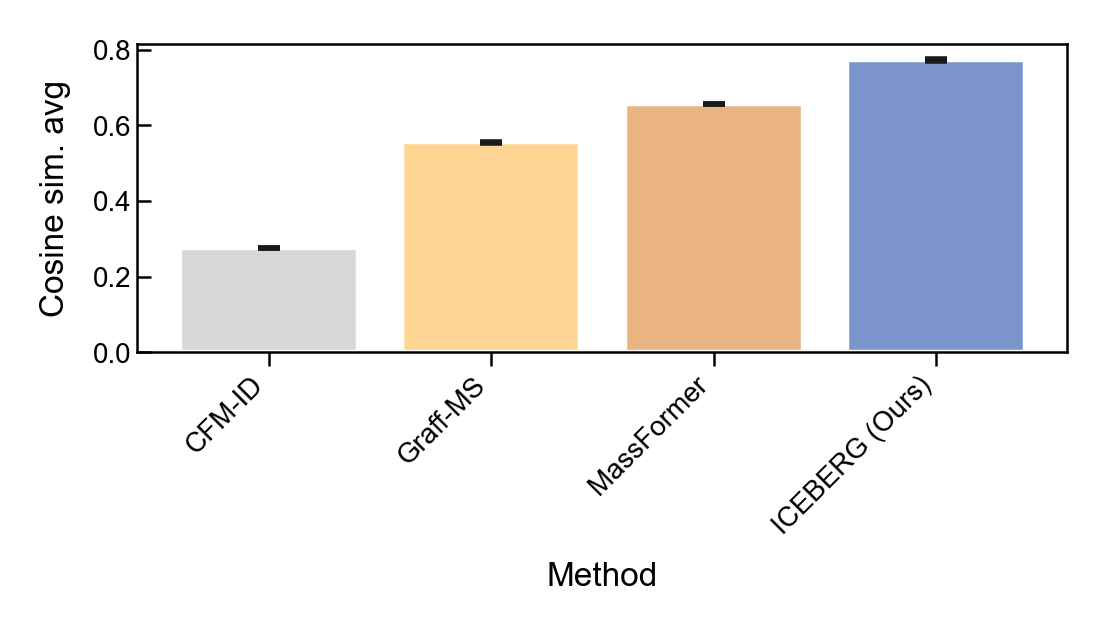

In [13]:
## Define Cosine sim bar plots

dataset = "split_1_nist20"
dataset_sub = out_df[["Method", "Cosine sim. orig", "Cosine sim. 95%", "Dataset"]].query(
    f"Dataset == '{dataset}'"
)
dataset_sub.set_index("Method", inplace=True)
fig = plt.figure(figsize=(3, 1), dpi=400)

ax = fig.gca()
dataset_sub = dataset_sub.loc[names]
sim = dataset_sub[["Cosine sim. orig"]].values.flatten()
errors = dataset_sub[["Cosine sim. 95%"]].values.flatten()
method_names = dataset_sub.index.values

ax.bar(method_names, sim, color=[method_colors[i] for i in method_names], 
    # errors
    yerr=errors,
    # Add style to make them visible
    capsize=2,
    
)

# Add 95% conf bars



ax.set_ylabel("Cosine sim. avg")
ax.set_xlabel("Method")
# Rotate x tick labels
ax.set_xticklabels(method_names, rotation=45, ha="right")

/tmp/ipykernel_477342/1042857173.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(method_names, rotation=45, ha="right", rotation_mode="anchor")
/tmp/ipykernel_477342/1042857173.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(method_names, rotation=45, ha="right", rotation_mode="anchor")


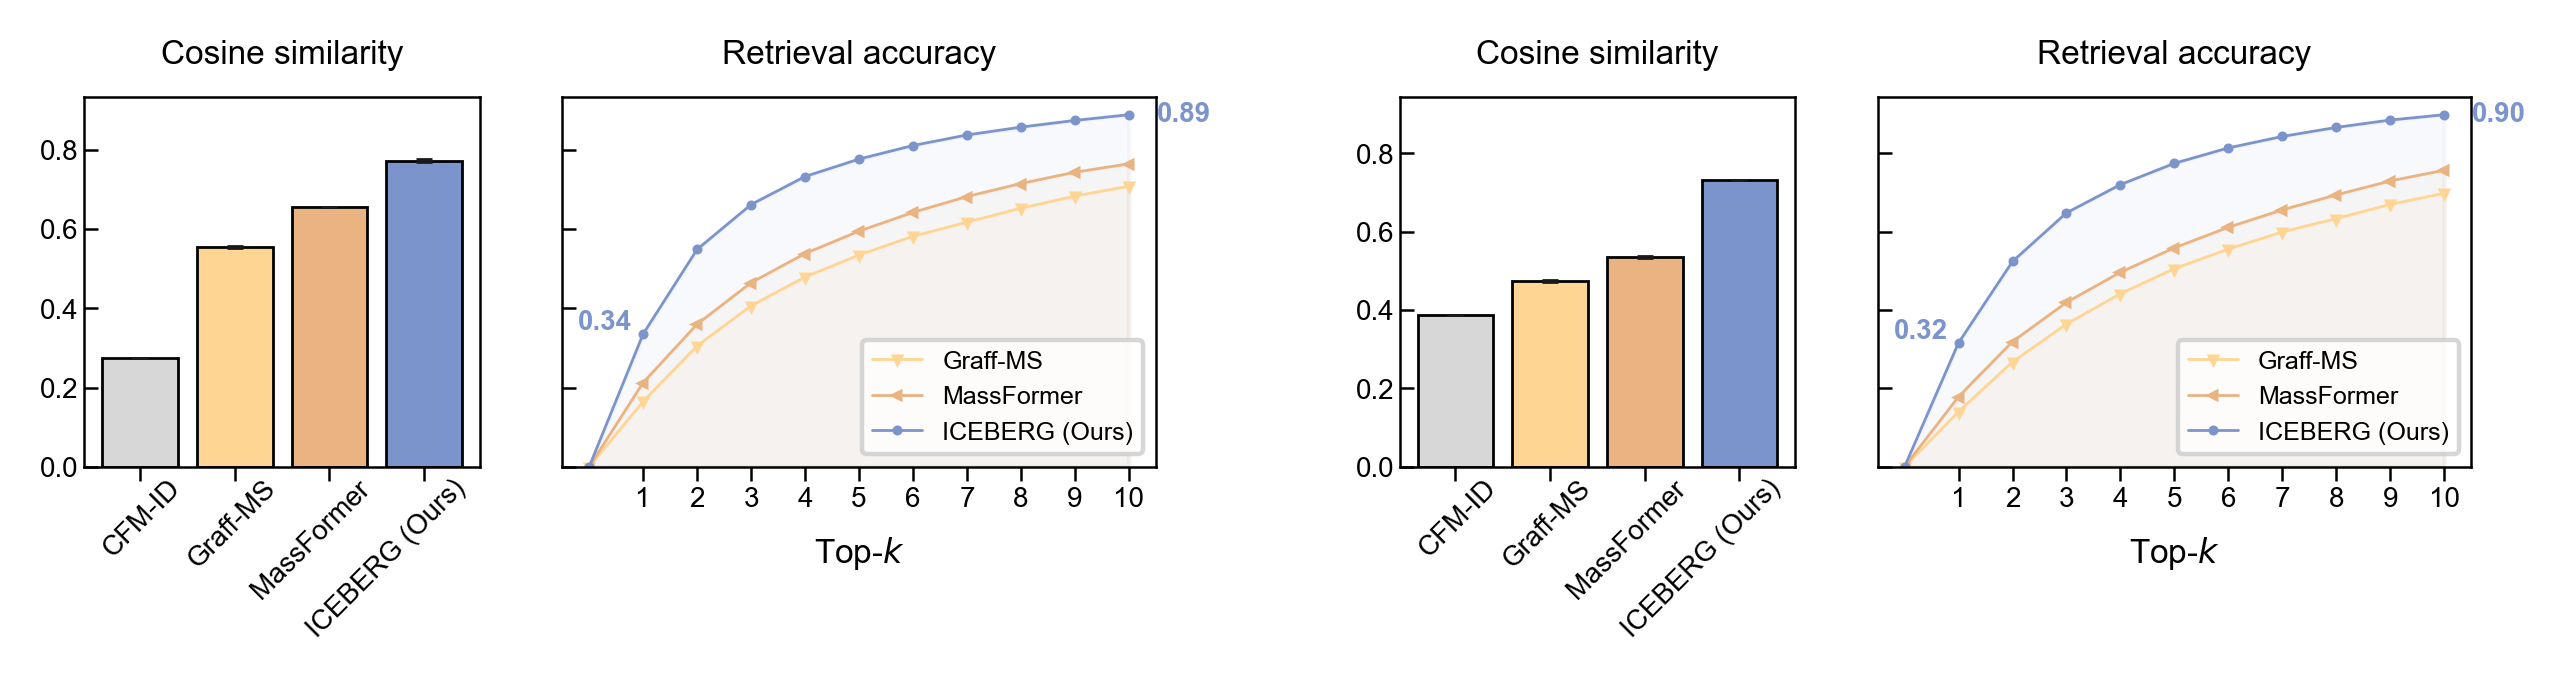

In [14]:
# Plot cosine similarities and time for 2 datasets
# define subplots
gridspec = dict(hspace=0.0, width_ratios=[1, 1.5, 0.2, 1, 1.5])
fig, axes = plt.subplots(
    1, 5, figsize=(7.7, 1.2), dpi=400, sharey=False, gridspec_kw=gridspec
)
plt_dataset_names = {"split_1_nist20": "InChIKey", "scaffold_1_nist20": "Scaffold"}

plot_datasets = [
    "split_1_nist20",
    "scaffold_1_nist20",
]
for ind, (cur_axes, dataset) in enumerate(zip([axes[0:2], axes[3:5]], plot_datasets)):
    # Cosine similarity plot
    ax = cur_axes[0]

    dataset_sub = out_df[
        ["Method", "Cosine sim. orig", "Cosine sim. 95%", "Dataset"]
    ].query(f"Dataset == '{dataset}'")
    dataset_sub.set_index("Method", inplace=True)
    dataset_sub = dataset_sub.loc[names]
    sim = dataset_sub[["Cosine sim. orig"]].values.flatten()
    _sem = dataset_sub[["Cosine sim. 95%"]].values.flatten()

    # Using sem compute 95% confidence interval and plot error bars
    ci = _sem * 1.96

    method_names = dataset_sub.index.values

    ax.bar(
        method_names,
        sim,
        color=[method_colors[i] for i in method_names],
        edgecolor="black",
        linewidth=0.5,
        yerr=ci,
        capsize=1.5,
        error_kw=dict(lw=0.5, capsize=1.5, capthick=0.5),
    )
    ax.set_title("Cosine similarity")
    # ax.set_xlabel("Method")
    # Rotate x tick labels
    ax.set_xticklabels(method_names, rotation=45, ha="right", rotation_mode="anchor")
    dx = 5/72.; dy = 2/72. 
    offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
    # apply offset transform to all x ticklabels.
    for label in ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + offset)
        
#     ax.set_title(plt_dataset_names.get(dataset))
    ax.yaxis.labelpad = 1
    
    # Retrieval acc plot
    ax = cur_axes[1]
    for method in names:
        sub_df = out_df[
            (out_df["Method"] == method) & (out_df["Dataset"] == dataset)
        ]
        topk, accs, error = [0], [0], [0]
        for i in range(1, 11):
            acc = sub_df[f"Top_{i} Retrieval"].item()
            err = sub_df[f"Top_{i} Retrieval 95%"].item()
            if acc != 0:
                topk.append(i)
                accs.append(acc)
                if err != 0:
                    error.append(err)
        marker = method_markers[method]
        if len(accs) > 1:
            ax.plot(
                topk,
                accs,
                color=method_colors[method],
                linewidth=0.5,
                label=method,
                marker=marker,
                markersize=0.8,
            )
            
            ax.legend(fontsize=4.5)
            
            ax.fill_between(
                topk,
                np.zeros_like(accs),
                np.array(accs),
                alpha=0.05,
                color=method_colors[method],
            )
        
        if method in ['ICEBERG (Ours)', 'ICEBERG (Goldman\'24)']:
            ax.text(topk[1]-0.2, accs[1]+0.01, f'{accs[1]:.2f}', 
                    horizontalalignment='right', fontsize=5, color=method_colors[method], fontweight='bold')
            ax.text(topk[-1]+0.52, accs[-1], f'{accs[-1]:.2f}', 
                    horizontalalignment='left', verticalalignment='center', fontsize=5, color=method_colors[method], fontweight='bold')
        
#         if len(error) > 1:
#             ax.fill_between(
#                 topk,
#                 np.array(accs) - np.array(error),
#                 np.array(accs) + np.array(error),
#                 alpha=0.2,
#                 color=method_colors[method],
#             )
    ax.xaxis.set_ticks(np.arange(1, 11))
    ax.set_xlabel("Top-$k$", fontfamily='arial')
    ax.set_title("Retrieval accuracy")

axes[0].get_shared_y_axes().join(axes[0], axes[1])
axes[1].set_xticklabels(list(range(1, 11)))
axes[1].set_yticklabels([])
axes[2].set_visible(False)
axes[3].get_shared_y_axes().join(axes[3], axes[4])
axes[4].set_xticklabels(list(range(1, 11)))
axes[4].set_yticklabels([])


# Save fig to file
fig.savefig(
    results_folder / "cosine_retrieval.pdf", bbox_inches="tight", transparent=True
)

In [15]:
# per-adduct type result for ICEBERG
all_dfs = []
for adduct_type in all_adducts:
    df = adduct_to_df[adduct_type]
    out_df_temp = df[df["Dataset"].isin(["split_1_nist20", "scaffold_1_nist20"])]
    out_df_temp = out_df_temp[out_df_temp["Method"].isin(['ICEBERG (Ours)'])]
    out_df_pivot = out_df_temp.pivot_table(
        index="Method",
        columns="Dataset",
        values=[
            f"Top-{i}" for i in range(1, 11)
        ],
        aggfunc=lambda x: x,
    )
#     out_df_pivot.index.name = 'Adduct type'
    out_df_pivot.rename(index={'ICEBERG (Ours)': adduct_type}, inplace=True)
    all_dfs.append(out_df_pivot)
out_df_pivot = pd.concat(all_dfs, axis=0)
out_df_pivot = out_df_pivot.fillna('-') # fill nan with '-'

out_df_pivot_sorted = out_df_pivot.swaplevel(0, 1, axis=1).round(3)


metric_order = [f"Top-{i}" for i in range(1, 11)]
dataset_order = ["split_1_nist20", "scaffold_1_nist20"]

# Create a new MultiIndex with the custom sort order
new_index = pd.MultiIndex.from_product(
    [dataset_order, metric_order], names=["Dataset", None]
)

out_df_pivot_sorted = out_df_pivot_sorted.loc[:, new_index]
out_df_pivot_sorted

out_df_pivot_sorted.index.name = None
latex = out_df_pivot_sorted.to_latex(
    caption="NIST adduct type retrieavl accuracy",
    label="tab:retrieval_per_adduct",
    escape=False,
)
print(latex)

\begin{table}
\caption{NIST adduct type retrieavl accuracy}
\label{tab:retrieval_per_adduct}
\begin{tabular}{lllllllllllllllllllll}
\toprule
Dataset & \multicolumn{10}{r}{split_1_nist20} & \multicolumn{10}{r}{scaffold_1_nist20} \\
 & Top-1 & Top-2 & Top-3 & Top-4 & Top-5 & Top-6 & Top-7 & Top-8 & Top-9 & Top-10 & Top-1 & Top-2 & Top-3 & Top-4 & Top-5 & Top-6 & Top-7 & Top-8 & Top-9 & Top-10 \\
\midrule
[M+H]+ & $0.400 \pm 0.008$ & $0.611 \pm 0.013$ & $0.721 \pm 0.010$ & $0.790 \pm 0.007$ & $0.829 \pm 0.006$ & $0.859 \pm 0.005$ & $0.881 \pm 0.006$ & $0.900 \pm 0.009$ & $0.913 \pm 0.008$ & $0.923 \pm 0.007$ & $0.335 \pm 0.005$ & $0.543 \pm 0.004$ & $0.669 \pm 0.006$ & $0.745 \pm 0.002$ & $0.799 \pm 0.004$ & $0.838 \pm 0.006$ & $0.867 \pm 0.005$ & $0.890 \pm 0.006$ & $0.907 \pm 0.009$ & $0.920 \pm 0.009$ \\
[M-H2O+H]+ & $0.238 \pm 0.007$ & $0.443 \pm 0.020$ & $0.556 \pm 0.014$ & $0.634 \pm 0.005$ & $0.685 \pm 0.009$ & $0.726 \pm 0.008$ & $0.754 \pm 0.011$ & $0.776 \pm 0.016$ & $0.802 \pm 

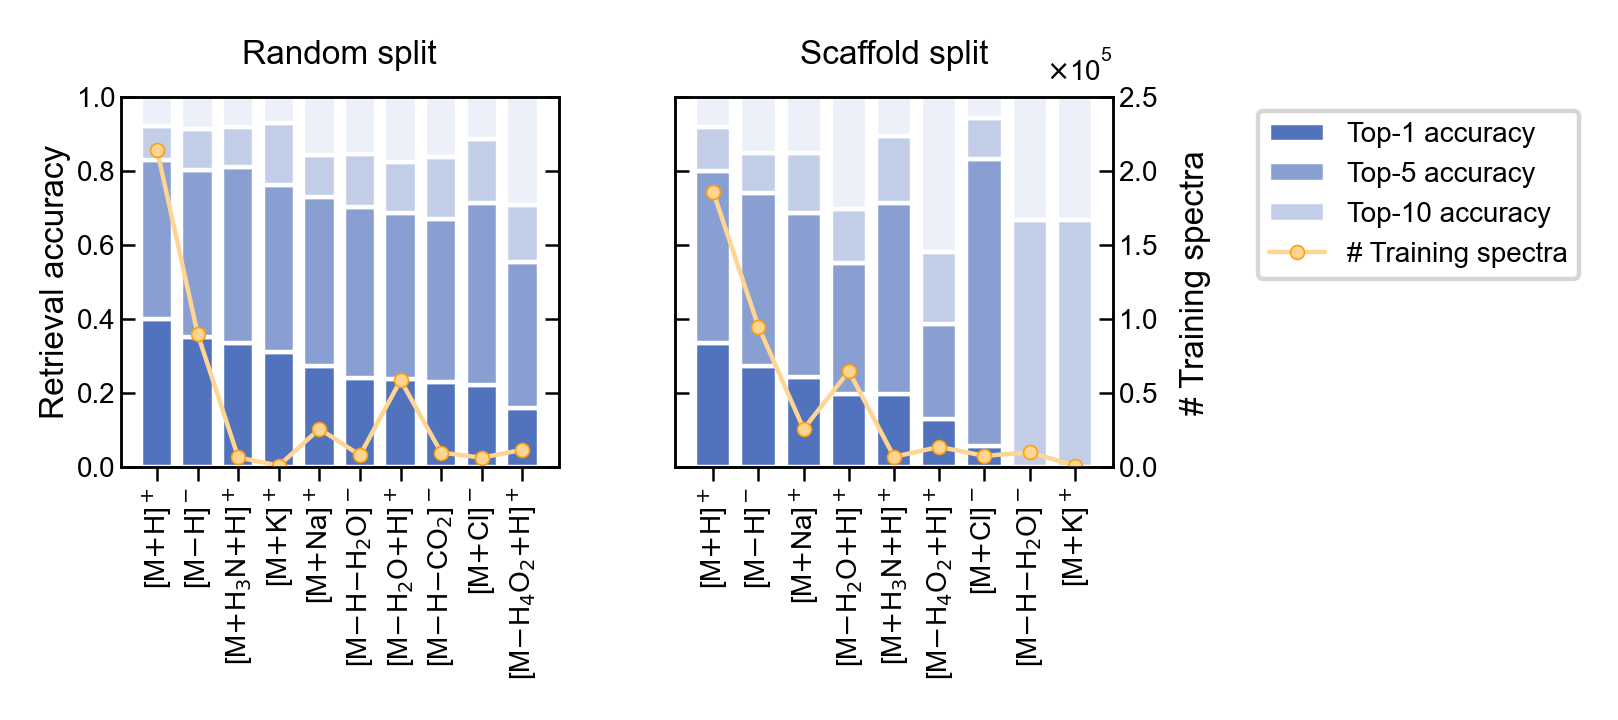

In [505]:
from matplotlib.ticker import ScalarFormatter

# 1) define your training‐size dicts
scaffold_sizes = {
    '[M+H]+': 185847,
    '[M+Na]+': 25460,
    '[M-H2O+H]+': 64581,
    '[M-H]-': 94755,
    '[M-H-H2O]-': 9679,
    '[M-H4O2+H]+': 13344,
    '[M+H3N+H]+': 6626,
    '[M+Cl]-': 7238,
    '[M+K]+': 694,
    '[M-H-CO2]-': 11588
}
random_sizes = {
    '[M+H]+': 214331,
    '[M+Na]+': 25582,
    '[M-H2O+H]+': 58426,
    '[M-H]-': 89875,
    '[M-H-H2O]-': 7720,
    '[M-H4O2+H]+': 11396,
    '[M+H3N+H]+': 6263,
    '[M+Cl]-': 6032,
    '[M+K]+': 622,
    '[M-H-CO2]-': 9504
}

# 2) set up your bar‐plot figure
gridspec = dict(hspace=0.0, width_ratios=[1, 0., 1])
fig, axes = plt.subplots(
    1, 3, figsize=(3.2, 1.2), dpi=400, sharey=False, gridspec_kw=gridspec
)
plt_dataset_names = {"split_1_nist20": "Random", "scaffold_1_nist20": "Scaffold"}

plot_datasets = ["split_1_nist20", "scaffold_1_nist20"]

second_axes = []

for ind, (ax, dataset) in enumerate(zip([axes[0], axes[2]], plot_datasets)):
    accs = []
    active_adducts = []
    for adduct_type in all_adducts:
        df = adduct_to_df[adduct_type]
        tmp = df[df["Dataset"] == dataset]
        tmp = tmp[tmp["Method"] == 'ICEBERG (Ours)']
        if not tmp.empty:
            accs.append([
                tmp['Top_1 Retrieval'].item(),
                tmp['Top_5 Retrieval'].item(),
                tmp['Top_10 Retrieval'].item()
            ])
            active_adducts.append(adduct_type)

    # sort by top‐1
    accs = np.array(accs)
    idx = np.argsort(accs[:, 0])[::-1]
    accs = accs[idx]
    active_adducts = np.array(active_adducts)[idx]

    # --- bars ---
    x = np.arange(len(active_adducts))
    ax.bar(x, accs[:, 0], color='#5172bc', label='Top-1 accuracy')
    ax.bar(x, accs[:, 1] - accs[:, 0], bottom=accs[:, 0], color='#899fd1', label='Top-5 accuracy')
    ax.bar(x, accs[:, 2] - accs[:, 1], bottom=accs[:, 1], color='#c2cde7', label='Top-10 accuracy')
    ax.bar(x, 1 - accs[:, 2], bottom=accs[:, 2], color='#ecf0f8')
    ax.set_xticks(x)

    # format adduct labels nicely
    labels = []
    for ad in active_adducts:
        pos = ad.endswith('+')
        s = ad[:-1].replace("2","$_2$").replace("3","$_3$").replace("4","$_4$")\
                    .replace("+","$+$").replace("-","$-$")
        labels.append(s + ('$^+$' if pos else '$^-$'))
    ax.set_xticklabels(labels, fontsize=5, rotation=90)
    ax.yaxis.labelpad = 1
    ax.set_title(f"{plt_dataset_names[dataset]} split")
    ax.set_ylim(0, 1)

    # --- twin axis for training size ---
    ax2 = ax.twinx()
    train_dict = scaffold_sizes if dataset == 'scaffold_1_nist20' else random_sizes
    sizes = [train_dict[ad] for ad in active_adducts]
    # plot with a marker edge
    line, = ax2.plot(
        x, sizes,
        marker='o', linestyle='-',
        markersize=2.5,
        linewidth=0.8,
#         color='#E9B382',
#         markeredgecolor='#d17625', markeredgewidth=0.3,
        color='#FFD593',
        markeredgecolor='#ffa00a', markeredgewidth=0.3,
        label='# Training spectra'
    )
    
    second_axes.append(ax2)

axes[0].set_ylabel('Retrieval accuracy')
axes[1].set_visible(False)
axes[0].get_shared_y_axes().join(axes[0], axes[2])
axes[0].set_ylim(0, 1)
axes[2].set_yticklabels([])
second_axes[0].get_shared_y_axes().join(second_axes[0], second_axes[1])
second_axes[0].set_yticklabels([])
second_axes[1].set_ylabel('# Training spectra')
second_axes[1].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
second_axes[1].ticklabel_format(axis='y', style='scientific', scilimits=(0,0))
second_axes[1].set_ylim(0, 2.5 * 1e5)

# 1. grab handles & labels from the bar‐axis (axes[2]) 
bar_h, bar_l = axes[2].get_legend_handles_labels()

# 2. grab handles & labels from the twin‐axis (second_axes[1])
line_h, line_l = second_axes[1].get_legend_handles_labels()

# 3. combine and draw one legend on axes[2]
axes[2].legend(
    bar_h + line_h, 
    bar_l + line_l,
    bbox_to_anchor=(1.3, 1),
)

fig.savefig(
    results_folder / "retrieval_by_adduct.pdf", bbox_inches="tight", transparent=True
)

## Retrieval accuracy with number of peaks

In [17]:
dataset_to_res = {}
for dataset_name in dataset_names:
    for split_name in ['split_1', 'scaffold_1']:
        tsv_files = defaultdict(lambda : [])
        for seed in [1,2,3]:    
            retrieval_path_entr = Path(f'../results/dag_inten_{dataset_name}/{split_name}_rnd{seed}/retrieval_{dataset_name}_{split_name}_50/rerank_eval_grouped_npeak_entropy.tsv')
            retrieval_path_cos = Path(f'../results/dag_inten_{dataset_name}/{split_name}_rnd{seed}/retrieval_{dataset_name}_{split_name}_50/rerank_eval_grouped_npeak_cos.tsv')
            if retrieval_path_entr.exists():
                retrieval_df = pd.read_csv(retrieval_path_entr, sep='\t')
            elif retrieval_path_cos.exists():
                retrieval_df = pd.read_csv(retrieval_path_cos, sep='\t')
            else:
                retrieval_df = None

            if retrieval_df is not None:
                retrieval_df = weighted_group_average(retrieval_df)

            tsv_files['ICEBERG (Ours)'].append(retrieval_df)

        dataset_to_res[f"{split_name}_{dataset_name}"] = tsv_files

In [18]:
dataset_to_res

{'split_1_nist20': defaultdict(<function __main__.<lambda>()>,
             {'ICEBERG (Ours)': [  Unnamed: 0  ind_recovered  total_decoys        mass  num_peaks_avg  \
               0     (0, 5]       4.902736     47.674772  242.494287       3.663714   
               1   (10, 15]       4.136292     47.656101  273.654171      12.458734   
               2   (15, 20]       3.775801     47.000000  287.056287      17.518306   
               3   (20, 25]       4.110647     47.686848  305.337005      22.260764   
               4   (25, 30]       3.889362     47.591489  313.063863      27.465529   
               5   (30, 40]       4.216783     47.039960  357.407587      35.167150   
               6  (40, 500]       6.040951     46.203435  415.925817      43.705241   
               7    (5, 10]       4.810345     47.646552  266.970878       7.542925   
               
                  true_dist     top_1     top_2     top_3     top_4     top_5     top_6  \
               0   0.209262  

In [19]:
mass_to_df = {}
for mass_label in ['(0, 5]', '(5, 10]', '(10, 15]', '(15, 20]', '(20, 25]', '(25, 30]', '(30, 40]', '(40, 500]']:
    out_df = []
    for dataset_name, tsv_files in dataset_to_res.items():
        for k, v in tsv_files.items():
            interested_rows = [vv[vv.iloc[:, 0] == mass_label] for vv in v]
            if any([len(row) == 0 for row in interested_rows]):
                continue
            def get_val(key):
                vals = []
                for row in interested_rows:
                    if key in row:
                        vals.append(row[key].item())
                return vals
            new_entry = {
                "Method": k,
                "Cosine sim.": np.mean(get_val('cos_sim')),
                "Cosine sim. 95%": 1.96 * sem(get_val('cos_sim')),

                "Cosine sim. (no PEP)": np.mean(get_val('cos_sim_zero_pep')),
                "Cosine sim. 95% (no PEP)": 1.96 * sem(get_val('cos_sim_zero_pep')),

                "Entropy sim.": np.mean(get_val('entropy_sim')),
                "Entropy sim. 95%": 1.96 * sem(get_val('entropy_sim')),

                "Coverage": np.mean(get_val('coverage')),
                "Coverage 95%": 1.96 * sem(get_val('coverage')),

                # The way of computing validity in this code base is outdated
                #"Valid": np.mean(get_val('frac_valid')),
                #"Valid 95%": 1.96 * sem(get_val('frac_valid')),

                "Dataset": dataset_name,
            }
            new_entry.update({
                f"Top_{i} Retrieval": np.mean(get_val(f"top_{i}")) for i in range(1, 11)
            })
            new_entry.update({
                f"Top_{i} Retrieval 95%": 1.96 * sem(get_val(f"top_{i}")) for i in range(1, 11)
            })
            out_df.append(new_entry)
    out_df = pd.DataFrame(out_df)

    # Replace nan with 0 
    out_df = out_df.fillna(0)
    
    mass_to_df[mass_label] = out_df


/home/runzhong/mambaforge/envs/ms-main/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/runzhong/mambaforge/envs/ms-main/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/runzhong/mambaforge/envs/ms-main/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/runzhong/mambaforge/envs/ms-main/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/runzhong/mambaforge/envs/ms-main/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


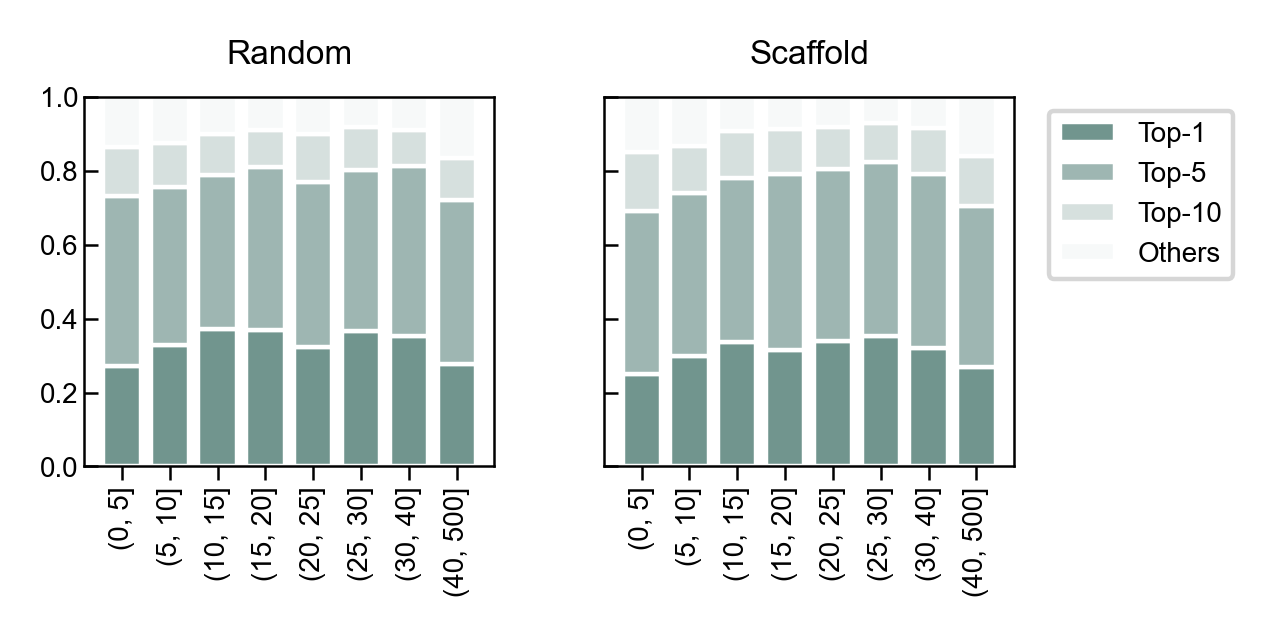

In [20]:
# retrieval accuracy for each adduct type
gridspec = dict(hspace=0.0, width_ratios=[1, 0.00, 1])
fig, axes = plt.subplots(
    1, 3, figsize=(3, 1.2), dpi=400, sharey=False, gridspec_kw=gridspec
)
plt_dataset_names = {"split_1_nist20": "Random", "scaffold_1_nist20": "Scaffold"}

plot_datasets = [
    "split_1_nist20",
    "scaffold_1_nist20",
]

for ind, (ax, dataset) in enumerate(zip([axes[0], axes[2]], plot_datasets)):
    accs = []
    active_adducts = []
    for mass_label in ['(0, 5]', '(5, 10]', '(10, 15]', '(15, 20]', '(20, 25]', '(25, 30]', '(30, 40]', '(40, 500]']:
        df = mass_to_df[mass_label]
        out_df_temp = df[df["Dataset"].isin([dataset])]
        out_df_temp = out_df_temp[out_df_temp["Method"].isin(['ICEBERG (Ours)'])]
        if len(out_df_temp) > 0:
            accs.append([out_df_temp['Top_1 Retrieval'].item(), 
                         out_df_temp['Top_5 Retrieval'].item(), 
                         out_df_temp['Top_10 Retrieval'].item()])
            active_adducts.append(mass_label)
    accs = np.array(accs)
    ax.bar(np.arange(len(active_adducts)), accs[:, 0], bottom=np.zeros(len(active_adducts)), color='#71958e', label='Top-1')
    ax.bar(np.arange(len(active_adducts)), accs[:, 1] - accs[:, 0], bottom=accs[:, 0], color='#9eb6b2', label='Top-5')
    ax.bar(np.arange(len(active_adducts)), accs[:, 2] - accs[:, 1], bottom=accs[:, 1], color='#d6e0de', label='Top-10')
    ax.bar(np.arange(len(active_adducts)), np.ones(len(active_adducts)) - accs[:, 2], bottom=accs[:, 2], color='#f7f9f9', label='Others')
    ax.set_xticks(range(len(active_adducts)))  # Ensure tick positions match the labels
    ax.set_xticklabels(active_adducts, fontsize=5)
    ax.tick_params(axis='x', labelrotation=90)
    ax.yaxis.labelpad = 1
    ax.set_title(plt_dataset_names[dataset])

axes[1].set_visible(False)
axes[0].get_shared_y_axes().join(axes[0], axes[2])
axes[0].set_ylim(0, 1)
axes[2].set_yticklabels([])

plt.legend(bbox_to_anchor=(1.05, 1))

fig.savefig(
    results_folder / "retrieval_by_npeaks.pdf", bbox_inches="tight", transparent=True
)

In [21]:
import yaml

# load yaml
yaml_path = '/home/runzhong/ms-pred/results/dag_inten_nist20/split_1_rnd1/retrieval_nist20_split_1_50/rerank_eval_entropy.yaml'
with open(yaml_path) as f:
    data = yaml.safe_load(f)


In [22]:
retrieval_df = pd.DataFrame(data['individuals'])
retrieval_df

,ind_recovered,ion,mass,mass_bin,num_peaks_avg,peak_bin_avg,peak_bin_max,peak_bin_min,spec_name,top_1,...,top_2,top_3,top_4,top_5,top_6,top_7,top_8,top_9,total_decoys,true_dist
0,1.0,[M+H]+,302.060628,300 - 400,35.600000,"(30, 40]","(40, 500]","(5, 10]",nist_1102083,True,...,True,True,True,True,True,True,True,True,50,0.304303
1,1.0,[M+H]+,229.062008,200 - 300,14.428571,"(10, 15]","(20, 25]","(0, 5]",nist_1102232,True,...,True,True,True,True,True,True,True,True,50,0.393764
2,1.0,[M-H2O+H]+,648.341066,600 - 700,35.666667,"(30, 40]","(40, 500]","(5, 10]",nist_1129613,True,...,True,True,True,True,True,True,True,True,50,0.523994
3,1.0,[M+Na]+,648.341066,600 - 700,34.142857,"(30, 40]","(40, 500]","(5, 10]",nist_1129624,True,...,True,True,True,True,True,True,True,True,50,0.427246
4,1.0,[M+H]+,762.185246,700 - 2000,33.071429,"(30, 40]","(40, 500]","(5, 10]",nist_1131501,True,...,True,True,True,True,True,True,True,True,1,0.417144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4920,48.0,[M+H]+,766.450342,700 - 2000,39.666667,"(30, 40]","(40, 500]","(10, 15]",nist_1291172,False,...,False,False,False,False,False,False,False,False,50,0.875114
4921,48.0,[M-H]-,250.044151,200 - 300,11.000000,"(10, 15]","(15, 20]","(5, 10]",nist_1354368,False,...,False,False,False,False,False,False,False,False,50,0.457010
4922,48.0,[M-H2O+H]+,297.157623,200 - 300,41.700000,"(40, 500]","(40, 500]","(20, 25]",nist_3284125,False,...,False,False,False,False,False,False,False,False,50,0.965187
4923,48.0,[M+Na]+,297.157623,200 - 300,28.800000,"(25, 30]","(40, 500]","(5, 10]",nist_3284188,False,...,False,False,False,False,False,False,False,False,50,0.851680


In [23]:
import seaborn as sns

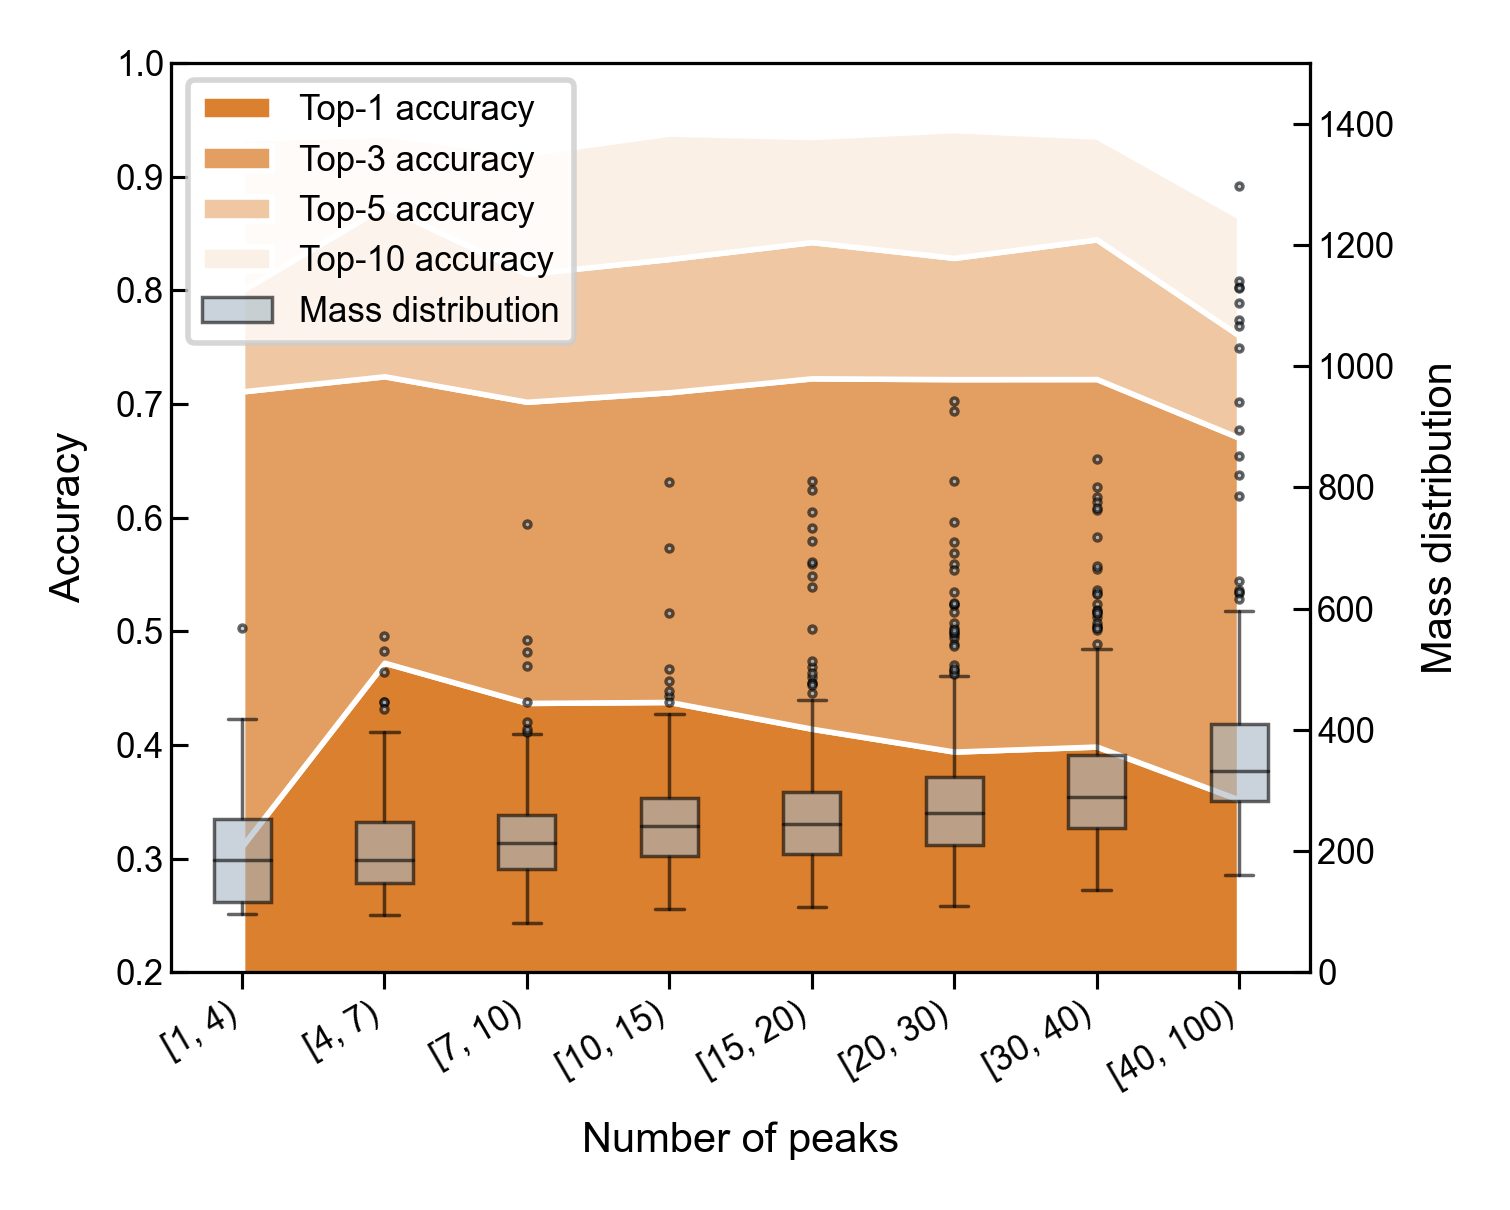

In [338]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

hplus_df = retrieval_df[retrieval_df['ion'] == '[M+H]+']

ind_recovered = np.array(hplus_df["ind_recovered"])
num_peaks_avg = np.array(hplus_df["num_peaks_avg"])
mass = np.array(hplus_df['mass'])

bins = [1, 4, 7, 10, 15, 20, 30, 40, 100]
top1acc = []
top3acc = []
top5acc = []
top10acc = []
mass_per_bin = []

for i in range(len(bins) - 1):
    min_peaks = bins[i]
    max_peaks = bins[i + 1]
    ind_select = np.logical_and(num_peaks_avg >= min_peaks, num_peaks_avg < max_peaks)
    rec_indices = ind_recovered[ind_select]
    mass_in_bin = mass[ind_select]

    top1acc.append(np.sum(rec_indices == 1) / rec_indices.shape[0])
    top3acc.append(np.sum(rec_indices <= 3) / rec_indices.shape[0])
    top5acc.append(np.sum(rec_indices <= 5) / rec_indices.shape[0])
    top10acc.append(np.sum(rec_indices <= 10) / rec_indices.shape[0])
    mass_per_bin.append(mass_in_bin)

x = np.arange(len(bins) - 1)
xtick_labels = [f'[{bins[i]:.0f}, {bins[i+1]:.0f})' for i in range(len(bins) - 1)]

# Convert to stacked area data
top1acc = np.array(top1acc)
top3acc = np.array(top3acc) - top1acc
top5acc = np.array(top5acc) - top3acc - top1acc
top10acc = np.array(top10acc) - top5acc - top3acc - top1acc

# Color mapping
colors = {
    'Top-1 Accuracy': '#da802f',
    'Top-3 Accuracy': '#e39f61',
    'Top-5 Accuracy': '#efc7a3',
    'Top-10 Accuracy': '#fbf0e6',
}

# Box plot style
boxplot_alpha = 0.6
box_linewidth = 0.5

fig, ax1 = plt.subplots(figsize=(3, 2.4), dpi=500)

# Plot stacked area chart
ax1.stackplot(
    x,
    top1acc,
    top3acc,
    top5acc,
    top10acc,
    labels=['Top-1 accuracy', 'Top-3 accuracy', 'Top-5 accuracy', 'Top-10 accuracy'],
    colors=[
        colors['Top-1 Accuracy'],
        colors['Top-3 Accuracy'],
        colors['Top-5 Accuracy'],
        colors['Top-10 Accuracy']
    ]
)

# Secondary axis for mass box plots
ax2 = ax1.twinx()
ax2.boxplot(
    mass_per_bin,
    positions=x,
    widths=0.4,
    patch_artist=True,
    boxprops=dict(facecolor='#A7B7C3', color='black', alpha=boxplot_alpha, linewidth=box_linewidth),
    medianprops=dict(color='black', alpha=boxplot_alpha, linewidth=box_linewidth),
    whiskerprops=dict(color='black', alpha=boxplot_alpha, linewidth=box_linewidth),
    capprops=dict(color='black', alpha=boxplot_alpha, linewidth=box_linewidth),
    flierprops=dict(markerfacecolor='#A7B7C3', marker='o', markersize=1, linestyle='none', alpha=boxplot_alpha, markeredgewidth=box_linewidth),
)

ax2.set_ylim(0, 1500)
ax2.set_ylabel('Mass distribution')

ax1.set_xticks(x)
ax1.set_xticklabels(xtick_labels, rotation=30, ha='right')
ax1.set_xlabel('Number of peaks')
ax1.set_ylim(0.2, 1)
ax1.set_ylabel('Accuracy')

box_legend = Patch(facecolor='#A7B7C3', edgecolor='black', label='Mass distribution', alpha=boxplot_alpha, linewidth=box_linewidth)

# Combine legends from both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = [box_legend], ['Mass distribution']
ax1.legend(handles=handles1 + handles2, labels=labels1 + labels2, loc='upper left', fontsize=5)

plt.tight_layout()
plt.show()

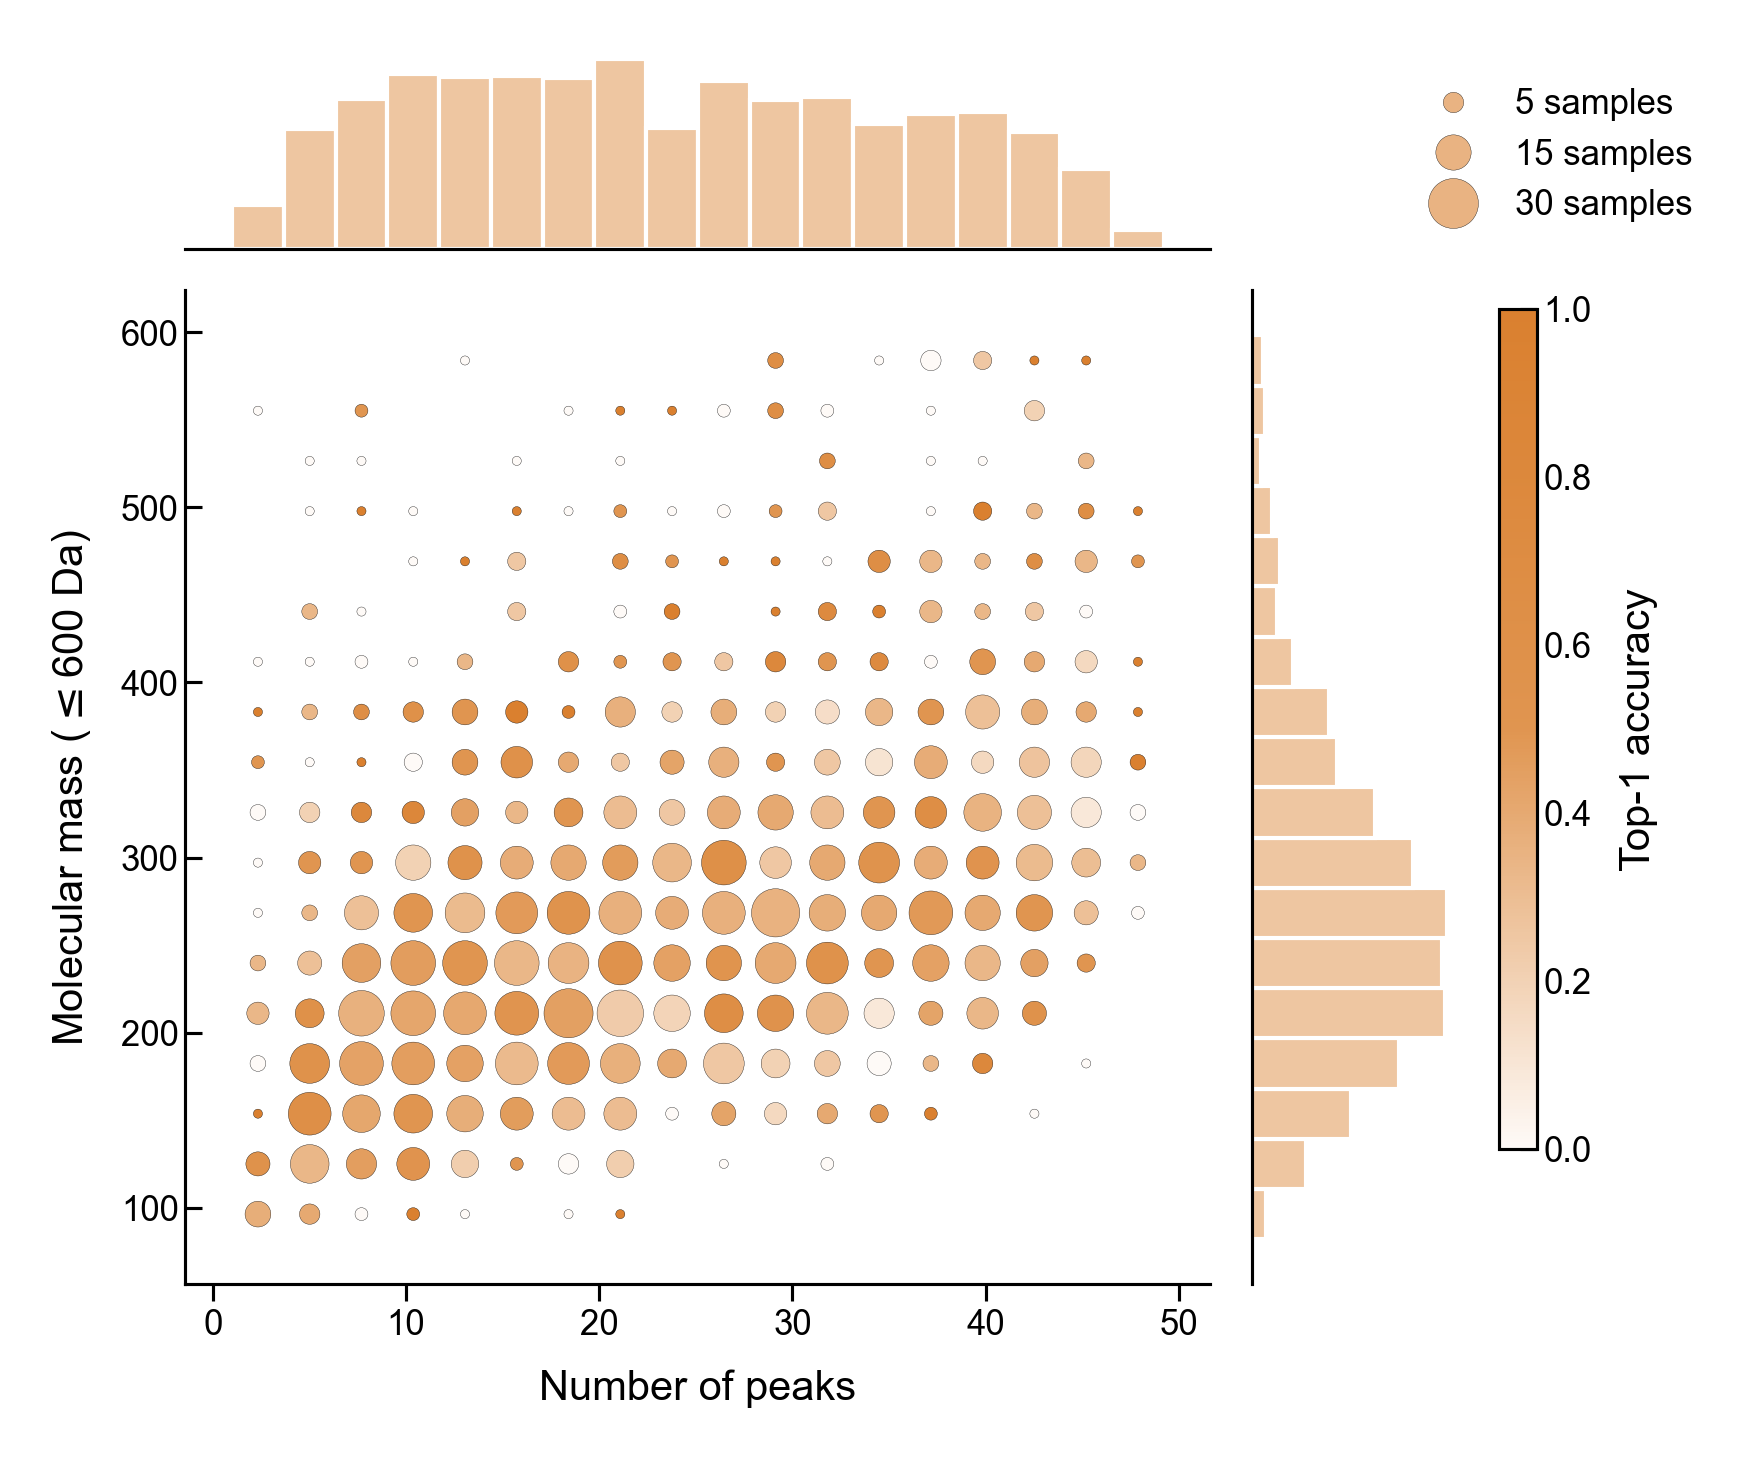

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import matplotlib.gridspec as gridspec
from scipy.stats import binned_statistic_2d

# Generate sample data
ind_recovered = np.array(hplus_df[hplus_df['mass'] < 600]["ind_recovered"])
num_peaks_avg = np.array(hplus_df[hplus_df['mass'] < 600]["num_peaks_avg"])
mass = np.array(hplus_df[hplus_df['mass'] < 600]["mass"])

left = num_peaks_avg
right = mass
third = ind_recovered

# Define 2D binning
bins = 18
stat_mean, xedges, yedges, binnumber = binned_statistic_2d(
    left, right, third, statistic=lambda x: np.sum(x <= 1) / len(x), bins=bins
)
stat_count, _, _, _ = binned_statistic_2d(
    left, right, None, statistic='count', bins=[xedges, yedges]
)

# Compute bin centers
x_centers = (xedges[:-1] + xedges[1:]) / 2
y_centers = (yedges[:-1] + yedges[1:]) / 2

# Flatten data for scatter plot
x_coords, y_coords = np.meshgrid(x_centers, y_centers, indexing='ij')
x_flat = x_coords.flatten()
y_flat = y_coords.flatten()
mean_flat = stat_mean.flatten()
count_flat = stat_count.flatten()

# Filter out NaNs and zero counts
mask = ~np.isnan(mean_flat) & (count_flat > 0)
x_plot = x_flat[mask]
y_plot = y_flat[mask]
color_plot = mean_flat[mask]
size_plot = count_flat[mask]

# Normalize sizes for better visibility
size_plot_scaled = 50 * (size_plot / size_plot.max())

# Create custom colormap
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('my_cmap', ['#fefaf7', '#e09550', '#da802f'])

# Create figure and GridSpec
fig = plt.figure(figsize=(3, 2.8), dpi=500, constrained_layout=True)
gs = gridspec.GridSpec(2, 3, width_ratios=[4, 0.8, 0.2], height_ratios=[0.8, 4], figure=fig)

ax_joint = fig.add_subplot(gs[1, 0])
ax_marg_x = fig.add_subplot(gs[0, 0], sharex=ax_joint)
ax_marg_y = fig.add_subplot(gs[1, 1], sharey=ax_joint)

# Scatter plot
sc = ax_joint.scatter(x_plot, y_plot, s=size_plot_scaled, c=color_plot, cmap=cmap, edgecolor='black', linewidth=0.05)

# Colorbar
cax = fig.add_axes([.98, 0.20, 0.025, 0.60])  # wider (0.025), taller (0.60)
cb = fig.colorbar(sc, cax=cax)
cb.set_label("Top-1 accuracy")

# Marginal histograms
sns.histplot(x=left, ax=ax_marg_x, bins=bins, color="#e9b382")
sns.histplot(y=right, ax=ax_marg_y, bins=bins, color="#e9b382")

# Turn off ticks for marginals
ax_marg_x.tick_params(axis='x', labelbottom=False)
ax_marg_y.tick_params(axis='y', labelleft=False)

# Remove top and right spines from joint plot
ax_joint.spines['top'].set_visible(False)
ax_joint.spines['right'].set_visible(False)

# Clean up marginal spines
for spine in ['top', 'right', 'left']:
    ax_marg_x.spines[spine].set_visible(False)
for spine in ['top', 'right', 'bottom']:
    ax_marg_y.spines[spine].set_visible(False)
    
# Hide labels
ax_marg_x.set_ylabel("")
ax_marg_y.set_xlabel("")

# Turn off ticks for marginals
ax_marg_x.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
ax_marg_y.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)

# Axis labels and title
ax_joint.set_xlabel("Number of peaks")
ax_joint.set_ylabel("Molecular mass ($\leq$600 Da)")

from matplotlib.lines import Line2D

# Create example sizes for legend
example_counts = [5, 15, 30] 
example_sizes = 50 * (np.array(example_counts) / size_plot.max())

# Create dummy scatter points
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=f'{int(count)} samples',
           markerfacecolor='#e9b382', markersize=np.sqrt(size), markeredgecolor='black', markeredgewidth=0.05)
    for count, size in zip(example_counts, example_sizes)
]

fig.legend(
    handles=legend_elements,
    loc='upper right',
    bbox_to_anchor=(1.13, 0.98),
    frameon=False,
)


plt.show()
fig.savefig(
    results_folder / "npeaks_mass_top1.pdf", bbox_inches="tight", transparent=True
)

# Fig 4 Chromatography

In [27]:
%pip install pyteomics

Note: you may need to restart the kernel to use updated packages.


In [213]:
from pyteomics import mzml, auxiliary
import os

fi = os.listdir('/home/datashare/msms_data/ullman_nitro_and_iodo_20250411')
mzml_files = []
for j in fi:
    if "blank" in j:
        continue
    if "pooled" in j: continue
    mzml_files.append(j)
print(len(mzml_files))

8


In [214]:
import numpy as np


all_xs = []
all_ys = []
for j in mzml_files:
    print(j)
    these_xs = []
    these_ys = []
    if "nitro" in j:
        tmz = 257.128
    elif "iodo" in j:
        tmz = 212.143
    with mzml.MzML('/home/datashare/msms_data/ullman_nitro_and_iodo_20250411/' + j) as reader:
        for i, spectrum in enumerate(reader):
            if i == 0:
                print(spectrum.keys())
            # if np.abs(spectrum["base peak m/z"]-tmz) < 0.001:
            #     print(spectrum["scanList"]['scan'][0]['scan start time'], spectrum["ms level"],
            #           spectrum["base peak m/z"], spectrum["base peak intensity"])
            #     these_ys.append(spectrum["base peak intensity"])
            # else:
            #     these_ys.append(0)
            found = False
            for idx,ii in enumerate(spectrum["m/z array"]):
                if np.abs(ii - tmz) < 0.001:
                    these_ys.append(spectrum["intensity array"][idx])
                    found = True
                    break
            if not found:
                these_ys.append(0)
            these_xs.append(spectrum["scanList"]['scan'][0]['scan start time'])
    all_xs.append(these_xs)
    all_ys.append(these_ys)
    print(len(these_ys), len(these_xs))

nitro_alkyl_ullman_20250411.mzML
dict_keys(['index', 'id', 'defaultArrayLength', 'scanList', 'MS1 spectrum', 'ms level', 'positive scan', 'profile spectrum', 'base peak m/z', 'base peak intensity', 'total ion current', 'lowest observed m/z', 'highest observed m/z', 'count', 'm/z array', 'intensity array'])
20051 20051
nitro_isopropylaniline_ullman_20250411.mzML
dict_keys(['index', 'id', 'defaultArrayLength', 'scanList', 'MS1 spectrum', 'ms level', 'positive scan', 'profile spectrum', 'base peak m/z', 'base peak intensity', 'total ion current', 'lowest observed m/z', 'highest observed m/z', 'count', 'm/z array', 'intensity array'])
20021 20021
nitro_benzyl_ullman_20250411.mzML
dict_keys(['index', 'id', 'defaultArrayLength', 'scanList', 'MS1 spectrum', 'ms level', 'positive scan', 'profile spectrum', 'base peak m/z', 'base peak intensity', 'total ion current', 'lowest observed m/z', 'highest observed m/z', 'count', 'm/z array', 'intensity array'])
19871 19871
iodo_isopropylaniline_ullman

In [215]:
pool_xs = []
pool_ys257 = []
pool_ys212 = []
with mzml.MzML('/home/datashare/msms_data/ullman_nitro_and_iodo_20250411/nitro_and_iodo_pooled_ullman_20250411.mzML') as reader:
    for i, spectrum in enumerate(reader):
        if i == 0:
            print(spectrum.keys())
        found257 = False
        found212 = False
        for idx,ii in enumerate(spectrum["m/z array"]):
            if not found257 and np.abs(ii - 257.128) < 0.001:
                pool_ys257.append(spectrum["intensity array"][idx])
                found257 = True
            if not found212 and np.abs(ii - 212.143) < 0.001:
                pool_ys212.append(spectrum["intensity array"][idx])
                found212 = True
            if found257 and found212:
                break
        if not found257:
            pool_ys257.append(0)
        if not found212:
            pool_ys212.append(0)
        pool_xs.append(spectrum["scanList"]['scan'][0]['scan start time'])


dict_keys(['index', 'id', 'defaultArrayLength', 'scanList', 'MS1 spectrum', 'ms level', 'positive scan', 'profile spectrum', 'base peak m/z', 'base peak intensity', 'total ion current', 'lowest observed m/z', 'highest observed m/z', 'count', 'm/z array', 'intensity array'])


In [216]:
# normlize peak intensities
pool_ys212 = np.array(pool_ys212)
pool_ys257 = np.array(pool_ys257)
all_ys = [np.array(ys) for ys in all_ys]
max_inten = max([np.max(pool_ys212) + np.max(pool_ys257)] + [np.max(ys) for ys in all_ys])

pool_ys212 = pool_ys212 / max_inten
pool_ys257 = pool_ys257 / max_inten
all_ys = [ys / max_inten for ys in all_ys]

In [235]:
np.sqrt(pool_ys212).max()

0.7884173073789708

### Load MS/MS for the coeluting peak

In [ ]:
from ms_pred import common

# mzs and intens are extracted from pooled experiment, raw data
all_mzs = [
[65.0387,74.6598,91.0543,91.9062,92.0495,93.0574,94.0652,101.0682,101.5591,106.0652,106.8943,109.4952,113.1854,117.7091,119.0855,120.0808,126.3508,135.1041,160.8612,169.0889,170.0965,180.0809,181.0886,194.0963,195.1040,196.1122,200.5151,212.1434],
[51.1133,51.7257,52.2547,53.0351,54.8757,56.2296,57.4192,57.7760,58.4713,58.6909,58.8861,62.1809,65.0386,67.2169,67.9829,78.7928,80.8177,83.7624,91.0543,91.9073,92.0496,93.0543,93.0574,94.0653,103.0545,106.0652,120.0809,120.0855,131.0731,134.0964,135.1042,150.6048,153.0700,155.4503,167.0737,168.0809,169.0885,170.0964,171.3577,180.0808,181.0886,182.0968,193.9541,194.0965,195.1044,196.1121,197.1199,208.6856,210.1277,212.1434,212.1643],
[51.0232,53.0350,65.0385,70.5860,72.6995,79.0542,82.9689,89.3041,91.0513,91.0543,91.9061,91.9091,92.0495,93.0573,94.0650,106.0650,120.0761,120.0808,134.0963,135.1042,137.9546,145.5597,149.8257,153.0697,168.0804,168.3178,169.0885,170.0963,180.0808,181.0885,182.0966,191.0895,194.0962,195.1043,196.1121,197.1197,210.1275,212.1433,212.6767],
[53.0351,54.5088,65.0387,91.0543,91.9076,92.0467,92.0496,93.0543,93.0574,94.0651,95.2928,106.0651,120.0809,123.1999,134.0965,135.1043,136.7619,137.9254,143.0854,153.0695,157.7873,168.0806,169.0888,170.0964,180.0808,181.0888,182.0966,194.0966,195.1045,196.1121,197.1207,210.1278,212.1320,212.1434],
[53.0351,65.0385,91.0543,91.9053,91.9083,92.0496,93.0574,94.0651,103.0545,106.0651,119.0857,120.0809,127.7293,131.0731,134.0965,135.1042,153.0697,165.4003,168.0809,169.0886,170.0964,180.0807,181.0886,182.0964,183.1041,194.0966,195.1044,196.1121,197.1197,210.1282,212.1434],
[53.0350,67.9866,71.9841,89.5372,91.0517,91.0544,92.0495,93.0574,103.0545,117.0698,117.3706,119.0855,120.0808,124.9924,134.0964,135.1042,137.3235,140.1042,168.0809,169.0887,170.0962,180.0808,181.0882,182.0966,183.1040,184.1120,194.0964,195.1041,196.1120,210.1279,212.1320,212.1434],
[53.0350,65.0386,79.0542,91.0543,91.9057,91.9085,92.0496,93.0574,93.0602,93.0698,103.0541,110.2593,117.0699,119.0731,119.0856,120.0808,123.5046,134.0963,135.1042,135.1097,169.0884,170.0965,178.9617,180.0807,181.0885,182.0964,183.1043,184.1120,194.0967,195.1043,196.1120,204.8851,210.1272,210.9980,212.1433,233.7700],
[53.0351,65.0385,67.1078,79.0543,91.0543,91.9066,92.0495,93.0547,93.0574,103.0542,104.0620,104.6086,106.0651,115.0541,117.0699,119.0729,119.0856,120.0808,120.0855,126.9029,134.0965,135.1042,142.2281,142.2337,169.0884,170.0966,180.0806,181.0886,182.0964,183.1043,184.1123,194.0964,195.1041,196.1122,197.1203,207.8730,210.1278,212.1433,227.9024],
[53.0351,53.4538,59.8154,65.0386,79.0543,85.1691,91.0543,91.9078,92.0495,92.8562,93.0574,93.0699,98.6425,103.0542,106.0651,115.0541,117.0699,119.0729,119.0856,119.5667,120.0808,120.5405,121.6822,134.0965,135.1042,135.1097,139.9886,153.8650,168.0813,169.0882,170.0965,178.4134,180.0805,181.0884,182.0965,183.1042,184.1123,194.0969,195.1043,196.1122,197.1201,198.8276,210.1277,212.1433]]
all_intens = [
[2.2E5,1.8E5,1.3E7,4.9E5,5.9E5,2.0E6,2.1E6,1.9E5,2.1E5,3.1E5,1.9E5,1.9E5,2.3E5,1.8E5,8.0E5,1.6E6,1.9E5,9.7E5,2.1E5,2.5E5,1.5E6,7.8E5,6.8E5,6.5E5,4.0E5,8.2E5,2.0E5,1.8E7],
[1.7E5,1.8E5,1.6E5,1.1E6,1.8E5,1.6E5,1.8E5,1.5E5,1.6E5,1.8E5,1.5E5,1.8E5,4.8E5,1.7E5,2.0E5,1.9E5,2.0E5,2.0E5,8.6E6,3.0E5,2.7E6,3.9E5,9.4E6,5.6E5,2.4E5,7.1E5,7.5E6,2.5E5,2.0E5,3.9E5,3.9E6,2.2E5,5.2E5,2.1E5,2.5E5,5.9E5,1.6E6,6.6E6,2.1E5,4.1E6,3.3E6,8.4E5,2.1E5,2.2E6,1.4E6,3.8E6,3.1E5,2.2E5,1.1E6,7.5E7,4.6E5],
[2.2E5,5.9E5,4.1E5,2.1E5,2.1E5,2.0E5,1.9E5,1.9E5,3.5E5,7.5E6,5.1E5,3.0E5,2.6E6,7.3E6,2.9E5,6.3E5,2.2E5,6.4E6,6.3E5,3.0E6,2.3E5,1.9E5,2.1E5,5.9E5,5.6E5,2.2E5,9.7E5,5.8E6,3.0E6,2.4E6,5.9E5,2.1E5,2.3E6,9.8E5,2.7E6,3.1E5,9.7E5,4.9E7,2.1E5],
[6.1E5,2.1E5,4.1E5,6.8E6,3.4E5,2.5E5,3.2E6,2.7E5,8.1E6,4.2E5,2.1E5,5.3E5,6.1E6,2.3E5,2.9E5,3.2E6,2.1E5,2.3E5,2.6E5,5.0E5,2.1E5,5.1E5,1.2E6,6.5E6,3.9E6,2.5E6,7.4E5,2.2E6,1.4E6,3.1E6,2.3E5,6.7E5,4.8E5,5.0E7],
[5.5E5,5.4E5,7.3E6,4.3E5,5.2E5,2.6E6,7.7E6,3.6E5,2.3E5,8.3E5,2.2E5,6.4E6,2.3E5,2.3E5,4.3E5,3.8E6,2.6E5,2.2E5,5.7E5,1.6E6,5.3E6,3.8E6,2.9E6,8.9E5,2.5E5,2.2E6,1.3E6,3.2E6,3.2E5,1.1E6,4.6E7],
[3.2E5,2.0E5,2.3E5,2.2E5,3.0E5,3.4E6,1.1E6,2.5E6,2.0E5,5.3E5,2.0E5,7.2E5,2.7E6,2.0E5,7.9E5,3.5E6,2.1E5,1.9E5,2.3E5,4.3E5,1.4E6,1.1E6,7.2E5,4.5E5,1.1E6,6.1E5,6.7E5,3.9E5,1.1E6,4.6E5,3.6E5,3.4E7],
[4.5E5,3.3E5,3.7E5,4.9E6,2.8E5,4.6E5,1.3E6,4.5E6,4.2E5,2.4E5,4.7E5,2.2E5,2.1E6,3.7E5,2.0E6,6.0E6,2.3E5,1.7E6,7.7E6,3.6E5,8.2E5,1.4E6,2.3E5,1.6E6,9.7E5,6.8E5,2.6E6,1.0E6,3.1E5,3.2E5,8.7E5,2.3E5,3.3E5,2.2E5,4.4E7,2.2E5],
[5.0E5,3.2E5,2.1E5,3.1E5,5.8E6,3.5E5,1.3E6,2.9E5,3.6E6,3.6E5,3.0E5,2.2E5,3.9E5,4.8E5,2.4E6,5.7E5,2.5E6,6.5E6,2.4E5,2.1E5,1.5E6,8.3E6,2.0E5,2.1E5,1.1E6,1.4E6,1.5E6,9.0E5,8.5E5,3.6E6,1.0E6,8.2E5,2.9E5,8.2E5,2.7E5,2.0E5,4.6E5,4.4E7,2.5E5],
[5.3E5,1.9E5,2.0E5,4.5E5,2.7E5,2.1E5,6.5E6,2.3E5,1.2E6,2.3E5,5.0E6,3.4E5,1.9E5,3.8E5,2.6E5,3.3E5,2.0E6,6.6E5,2.3E6,2.2E5,6.2E6,2.0E5,1.9E5,1.9E6,8.4E6,2.0E5,2.2E5,2.1E5,2.8E5,1.0E6,1.8E6,2.0E5,1.1E6,1.1E6,7.6E5,3.8E6,1.5E6,5.5E5,6.3E5,1.1E6,4.8E5,2.2E5,5.3E5,4.9E7]
]

all_peaks = [(str(i), np.array([[mz, inten] for inten, mz in zip(all_intens[i], all_mzs[i])])) for i in range(0, 2)]
spec_elute1 = common.process_spec_file({"parentmass": 212.1432}, all_peaks, precision=3)
spec_elute1 = common.max_inten_spec(spec_elute1, inten_thresh=0.1)
common.plot_ms(spec_elute1)
for mz, inten in spec_elute1:
    if inten > 0.2:
        plt.text(mz, inten + 0.06, f'{mz:.4f}', fontsize=4, alpha=0.7, horizontalalignment='center')


all_peaks = [(str(i), np.array([[mz, inten] for inten, mz in zip(all_intens[i], all_mzs[i])])) for i in range(7, 9)]
spec_elute2 = common.process_spec_file({"parentmass": 212.1432}, all_peaks, precision=3)
spec_elute2 = common.max_inten_spec(spec_elute2, inten_thresh=0.1)
common.plot_ms(spec_elute2)
for mz, inten in spec_elute2:
    if inten > 0.2:
        plt.text(mz, inten + 0.06, f'{mz:.4f}', fontsize=4, alpha=0.7, horizontalalignment='center')

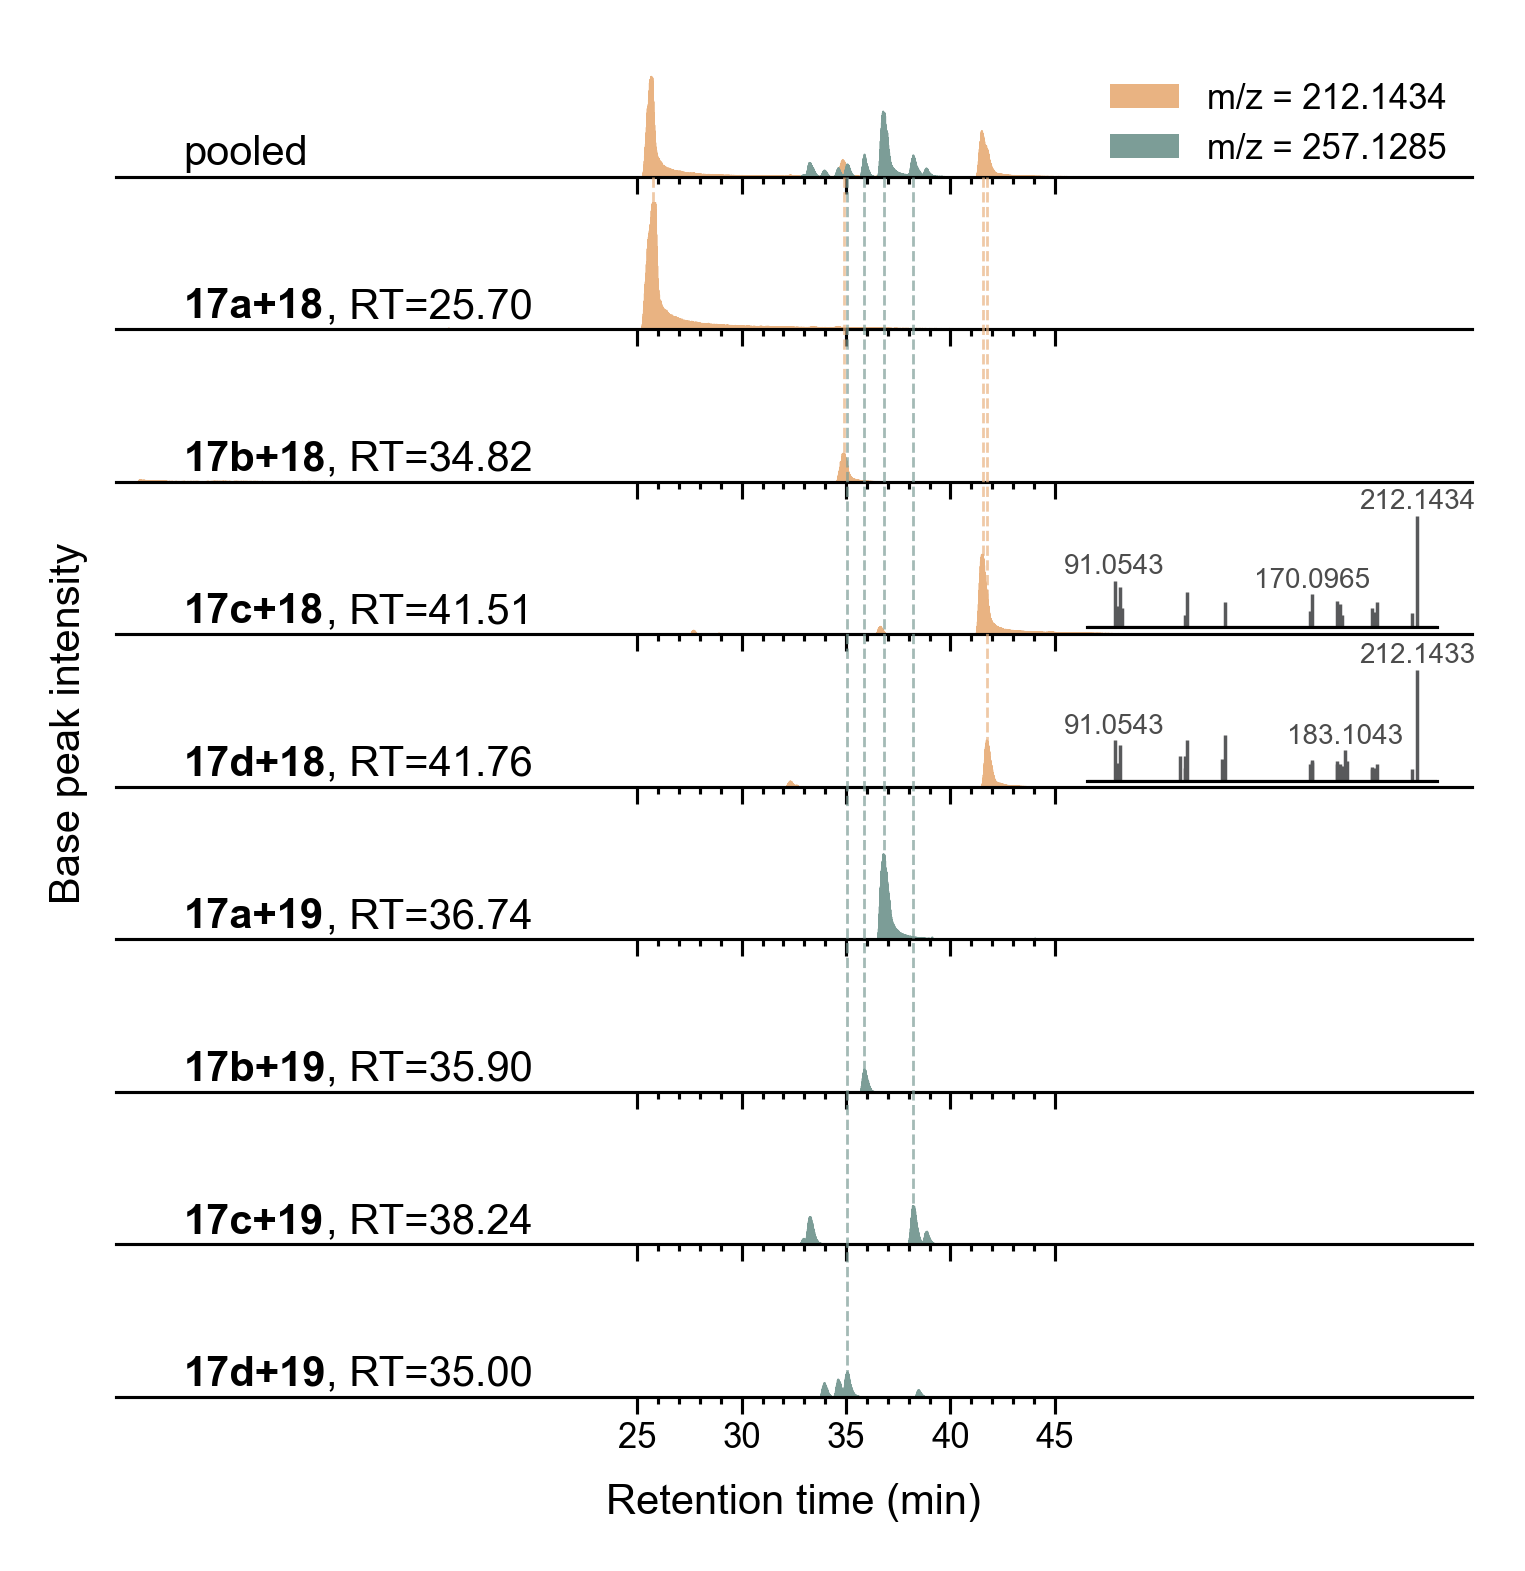

In [423]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
from matplotlib.patches import Patch

fig = plt.figure(figsize=(3.5, 3.5), dpi=500)
gs = gridspec.GridSpec(9, 1, hspace=0.2)

ax_pool = plt.subplot(gs[0, 0])
ax_indi = [plt.subplot(gs[i+1, 0], sharex=ax_pool, sharey=ax_pool) for i in range(8)]

ax_pool.plot(np.array(pool_xs), np.sqrt(pool_ys212), color='#e9b382', linewidth=0.3)
ax_pool.plot(np.array(pool_xs), np.sqrt(pool_ys257), color='#7c9d97', linewidth=0.3)
ax_pool.set_yticks([])
ax_pool.tick_params(axis='x', labelbottom=False)
ax_pool.tick_params(axis='x', which='minor', length=1)
ax_pool.text(0.05, 0.18, "pooled", transform=ax_pool.transAxes, ha='left', va='center', rotation=0)
ax_pool.set_xlim(0, 65)
ax_pool.set_ylim(0.02, 1)

# turn off boxes
for spine in ['top', 'right', 'left']:
    ax_pool.spines[spine].set_visible(False)

plot_order = [4, 6, 3, 7, 0, 2, 1, 5]
xtick_pos = [25, 30, 35, 40, 45]
xminortick_pos = [i for i in range(xtick_pos[0], xtick_pos[-1]) if not i in xtick_pos]

name0_to_bb = {'nitro': '19', 'iodo': '18'}
name1_to_bb = {'alkyl': '17a', 'benzyl': '17b', 'isopropylaniline': '17c', 'meth-eth-aniline': '17d'}
name_to_rt = {'iodo-alkyl': '25.70', 'iodo-benzyl': '34.82', 'iodo-isopropylaniline': '41.51', 'iodo-meth-eth-aniline': '41.76',
             'nitro-alkyl': '36.74', 'nitro-benzyl': '35.90', 'nitro-isopropylaniline': '38.24', 'nitro-meth-eth-aniline': '35.00'}

for pidx, i in enumerate(plot_order):
    names = mzml_files[i].split(".")[0].split("_")[0:2]
    color = '#7c9d97' if names[0] == 'nitro' else '#e9b382'

    ax = ax_indi[pidx]
    ax.plot(all_xs[i], np.sqrt(all_ys[i]), color=color, linewidth=0.3)
    ax.set_yticks([])
    ax.set_xticks(xtick_pos)
    ax.set_xticks(xminortick_pos, minor=True)
    ax.tick_params(axis='x', labelbottom=False)
    ax.tick_params(axis='x', which='minor', length=1)

    ax.text(0.05, 0.18, f'{name1_to_bb[names[1]]}+{name0_to_bb[names[0]]}', weight='bold',
            transform=ax.transAxes, ha='left', va='center', rotation=0)
    ax.text(0.155, 0.18, f', RT={name_to_rt["-".join(names)]}',
            transform=ax.transAxes, ha='left', va='center', rotation=0)

    for spine in ['top', 'right', 'left']:
        ax.spines[spine].set_visible(False)
        
    # Find highest peak x location in data coordinates
    x_peak = all_xs[i][np.argmax(all_ys[i])]

    # Convert data x-coordinate to figure normalized coordinate
    x_fig = ax.transData.transform((x_peak, 0))[0]
    x_fig_norm = fig.transFigure.inverted().transform((x_fig, 0))[0]

    # Get y limits for the pooled subplot and current subplot in figure coords
    y0 = ax_pool.get_position().y0  # bottom of ax_pool
    y1 = ax.get_position().y0       # bottom of current subplot

    # Add a vertical dashed line across subplots using figure coordinates
    line = plt.Line2D(
        [x_fig_norm, x_fig_norm], [y0, y1 + 0.01],
        transform=fig.transFigure,
        linestyle='--',
        linewidth=0.4,
        color=color,
        alpha=0.7,
        zorder=1
    )
    fig.lines.append(line)

# Define legend handles using rectangle patches
legend_handles = [
    Patch(facecolor='#e9b382', edgecolor='none', label='m/z = 212.1434'),
    Patch(facecolor='#7c9d97', edgecolor='none', label='m/z = 257.1285')
]

# Add custom legend to upper left with padding
ax_pool.legend(
    handles=legend_handles,
    loc='upper left',
    bbox_to_anchor=(0.71, 0.99),
    frameon=False,
)

ax_indi[3].set_ylabel('Base peak intensity')
ax_indi[7].tick_params(axis='x', labelbottom=True)
ax_indi[7].set_xticklabels(xtick_pos)
ax_indi[7].set_xlabel('Retention time (min)')

# --- Add Floating (Inset) MS/MS Panels ---
# Here we add two inset axes to float on top of the LC plot.
# Adjust the positions ([left, bottom, width, height] in figure fraction coordinates) as desired.
inset_ax1 = fig.add_axes([0.68, 0.55, 0.2, 0.07])  # Example: top-right corner inset
common.plot_ms(spec_elute1, ax=inset_ax1, spec_name="")
for spine in ['top', 'right', 'left']:
    inset_ax1.spines[spine].set_visible(False)
inset_ax1.set_facecolor("none")
inset_ax1.set_yticks([])
inset_ax1.set_yticks([], minor=True)
inset_ax1.set_xticks([])
inset_ax1.set_xlabel("")
inset_ax1.set_ylabel("")
inset_ax1.set_xlim(80, 220)
# Optionally, label the peaks on the inset:
for mz, inten in spec_elute1:
    if inten > 0.25 and (mz > 170 or mz < 93):
        inset_ax1.text(mz, inten + 0.06, f'{mz:.4f}', fontsize=4, alpha=0.7, horizontalalignment='center')

inset_ax2 = fig.add_axes([0.68, 0.462, 0.2, 0.07])  # Example: below the first inset
common.plot_ms(spec_elute2, ax=inset_ax2, spec_name="")
for spine in ['top', 'right', 'left']:
    inset_ax2.spines[spine].set_visible(False)
inset_ax2.set_facecolor("none")
inset_ax2.set_yticks([])
inset_ax2.set_yticks([], minor=True)
inset_ax2.set_xticks([])
inset_ax2.set_xlabel("")
inset_ax2.set_ylabel("")
inset_ax2.set_xlim(80, 220)
for mz, inten in spec_elute2:
    if inten > 0.25 and (mz > 170 or mz < 93):
        inset_ax2.text(mz, inten + 0.06, f'{mz:.4f}', fontsize=4, alpha=0.7, horizontalalignment='center')

plt.show()
fig.savefig(
    results_folder / "pooled_bh_lc.pdf", bbox_inches="tight", transparent=True
)

# Fig 4 pooled vs unpooled regression

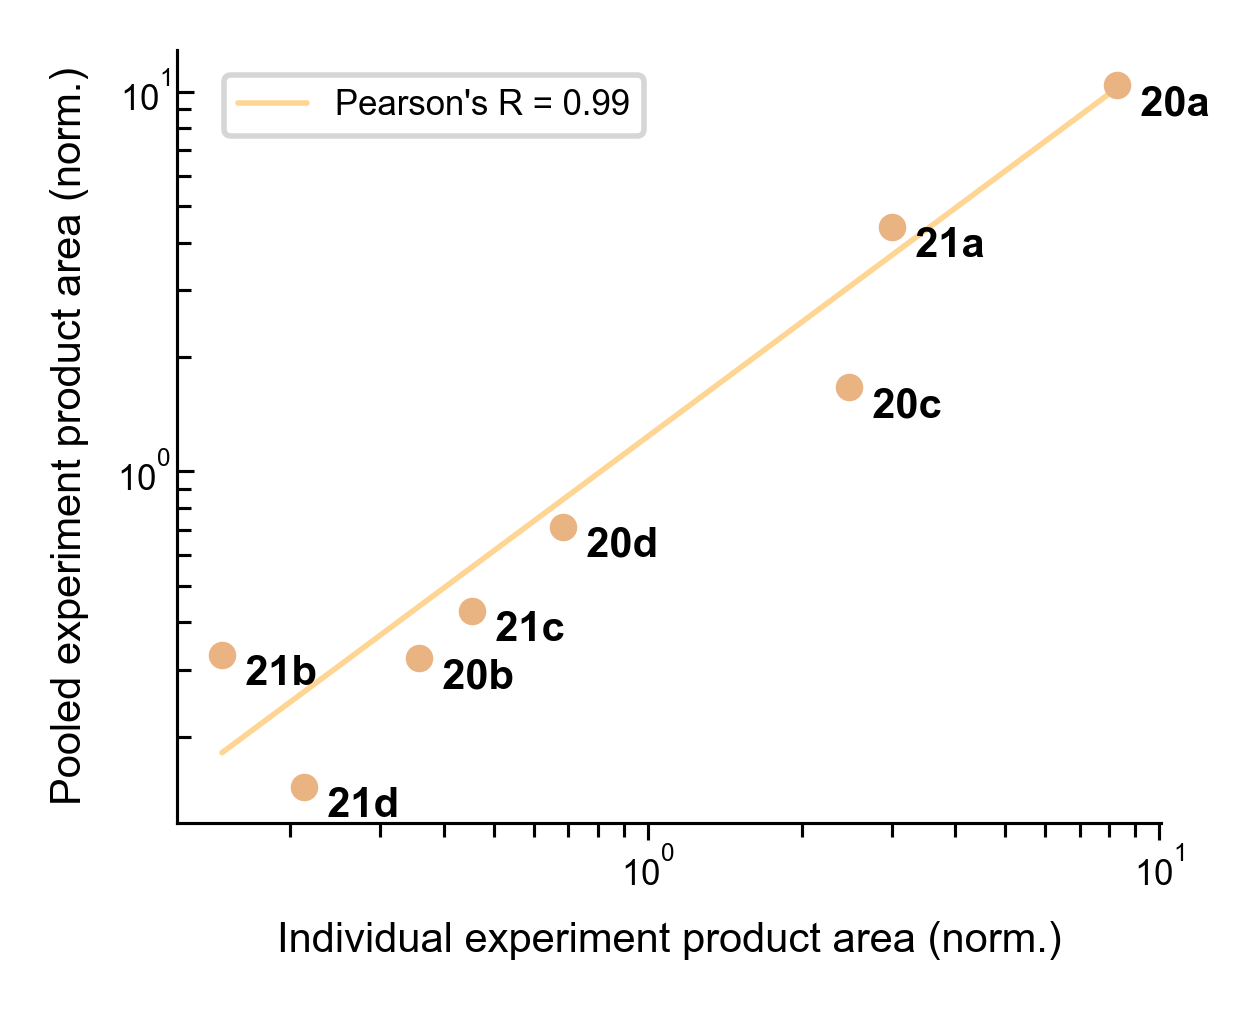

In [421]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t

fig = plt.figure(figsize=(2.5, 2.), dpi=500)

# Provided data
labels = ['20a', '20c', '20d', '20b', '21a', '21b', '21d', '21c']
individual_areas = np.array([8.27, 2.48, 0.683, 0.357, 3.00, 0.147, 0.213, 0.454])
pooled_areas = np.array([10.4, 1.666, 0.714, 0.322, 4.39, 0.328, 0.147, 0.428])

n = len(individual_areas)  # number of data points

###############################################################################
# NORMAL SCALE REGRESSION (Additive Model, forced through origin)
###############################################################################
# Compute the slope forcing the regression through 0:
slope_norm = np.sum(individual_areas * pooled_areas) / np.sum(individual_areas**2)
intercept_norm = 0  # forced through origin

def regression_line_norm(x):
    return slope_norm * x

# Predicted values and RMSE for the normal regression
predicted_norm = regression_line_norm(individual_areas)
rmse_norm = np.sqrt(np.mean((predicted_norm - pooled_areas)**2))

# Define x values (for plotting the regression line)
x_vals = np.linspace(individual_areas.min(), individual_areas.max(), 100)
y_vals_norm = regression_line_norm(x_vals)

###############################################################################
# Compute Pearson's correlation coefficient (R)
###############################################################################
pearson_r = np.corrcoef(individual_areas, pooled_areas)[0, 1]

###############################################################################
# PLOTTING (displayed on log scale)
###############################################################################
# Plot the data points
plt.scatter(individual_areas, pooled_areas, color='#E9B382', zorder=3, s=10)

# Set log scale for both axes
plt.xscale('log')
plt.yscale('log')

# Add labels for each point
for x, y, lab in zip(individual_areas, pooled_areas, labels):
    plt.text(x, y, f'  {lab}', verticalalignment='top', weight='bold')

# Plot the regression line with RMSE and Pearson's R in the legend
plt.plot(x_vals, y_vals_norm, color='#FFD593', linewidth=0.8, 
         label=f"Pearson's R = {pearson_r:.2f}")
# RMSE = {rmse_norm:.4f}, 

# Label the axes
plt.xlabel('Individual experiment product area (norm.)')
plt.ylabel('Pooled experiment product area (norm.)')

for spine in ['top', 'right']:
    plt.gca().spines[spine].set_visible(False)

plt.legend(loc='upper left',
    bbox_to_anchor=(0.03, 0.99))
plt.tight_layout()
plt.show()

fig.savefig(
    results_folder / "pooled_vs_individual.pdf", bbox_inches="tight", transparent=True
)

In [26]:
assert 1 == 2  # please call seaborn manually; calling seaborn will break matplotlib config

AssertionError: 

In [ ]:
import matplotlib.ticker as ticker

sns.set_theme(rc={'figure.figsize': (3, 2.4), 
                  'figure.dpi': 500, 
                  'axes.edgecolor': 'black',
                  'axes.labelcolor': 'black',
                  'text.color': 'black',
                  'xtick.color': 'black',
                  'ytick.color': 'black'}, style="white", font="Arial")

retrieval_df["true_sim"] = 1 - retrieval_df["true_dist"] # distance to similarity

# g = sns.jointplot(
#     data=retrieval_df[retrieval_df['mass'] < 600],
#     x="true_sim",
#     y="mass",
#     kind="hex",
#     color="#71958e",
#     marginal_kws=dict(bins=30)
# )

g = sns.JointGrid(
    data=retrieval_df[retrieval_df['mass'] < 600],
    x="true_sim",
    y="mass",
    marginal_ticks=True,
    space=0
)

# Plot the hexbin manually without edge lines
g.ax_joint.hexbin(
    retrieval_df[retrieval_df['mass'] < 600]['true_sim'],
    retrieval_df[retrieval_df['mass'] < 600]['mass'],
    gridsize=30,
    cmap=matplotlib.colors.LinearSegmentedColormap.from_list('my_cmap', ['#ffffff', '#71958b', '#1c2623']),
    linewidths=0.1  # removes edgewidth
)

# Add marginal histograms
sns.histplot(
    data=retrieval_df[retrieval_df['mass'] < 600],
    x="true_sim",
    ax=g.ax_marg_x,
    bins=30,
    color="#71958e"
)
sns.histplot(
    data=retrieval_df[retrieval_df['mass'] < 600],
    y="mass",
    ax=g.ax_marg_y,
    bins=30,
    color="#71958e"
)

# Clean up marginal spines
for spine in ['top', 'right', 'left']:
    g.ax_marg_x.spines[spine].set_visible(False)
for spine in ['top', 'right', 'bottom']:
    g.ax_marg_y.spines[spine].set_visible(False)

# Hide labels
g.ax_marg_x.set_ylabel("")
g.ax_marg_y.set_xlabel("")

# Turn off ticks for marginals
g.ax_marg_x.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
g.ax_marg_y.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)


g.ax_joint.tick_params(left=True, bottom=True)
g.ax_joint.tick_params(axis="y",direction="in", pad=2)

# Set axis labels
g.ax_joint.set_xlabel("Entropy similarity")
g.ax_joint.set_ylabel("Molecular mass ($\leq$600 Da)")

plt.tight_layout()
plt.show()
g.savefig(
    results_folder / "mass_entropy.pdf", bbox_inches="tight", transparent=True
)